# Neural ODE for Continuous Normalizing Flows from Gaussian to Cellular Distribution
<hr>
<div style="text-align:right">
  <b>CPSC 552</b>: Deep Learning Theory and Applications 
</div>

<div style="display:inline-flex; width:100%; text-align:left!important">
    <table style="display:flex; width:100%; text-align:left!important">
      <tr style="text-align:left!important">
        <td>Course Instructor</td>
        <td><a href="https://krishnaswamylab.org">Smita Krishnaswamy</a></td> 
      </tr>
      <tr>
        <td>Notebook by</td>
        <td>Sumner Magruder</td> 
      </tr>
    </table>
    
</div>

## Problem formulation

Data generation has a wide range of applications from creative uses (e.g. image generation as now is rampant with Stable Diffusion) to data augmentation (i.e. creating underrepresented or hard to obtain data samples). In this problem we aim to learn how to implement a Neural ODE to transport from a Gaussian distribution to a distribution of cells. In order to do this, we first download and process some high-throughput cellular data. Thereafter, we set up the NeuralODE that implements transport, and finally generate cells from our model. 

<hr>

## Imports

In [1]:
# Standard Libraries
import os, pickle, requests, zipfile, io, warnings
from pathlib import Path
warnings.filterwarnings('ignore', category=UserWarning)
from tqdm.autonotebook import tqdm

from cpus import numcores

# Typing
from typing import Any, Generator, TypeVar, Iterable, TypedDict

# Data Libraries
import numpy as np, pandas as pd
import phate, magic, scprep
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Plotting Libraries
import matplotlib.pyplot as plt, seaborn as sns

# PyTorch
import torch, torch.nn as nn, torch.optim as optim, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

# TorchDyn
import ot
from torchdyn.core import NeuralODE
from torchdyn.datasets import *
from torchdyn.nn import Augmenter
from torchdyn.models import CNF

# PyTorch Lightning
from pytorch_lightning import Trainer, LightningModule

/tmp/ipykernel_46776/3642238658.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## Paths & Core

In [2]:
T = TypeVar('T')

SAVE_DIR = Path('.').expanduser().absolute()

FIGS_DIR = SAVE_DIR / 'figures'

# NOTE: set this to be wherever you saved your data
DATA_DIR = SAVE_DIR / 'data'
EB_DATA_DIR = DATA_DIR / 'scRNAseq'

EMB_FILE = DATA_DIR / 'df_phate.pkl'
PHATE_FILE = DATA_DIR / 'phate_op.pkl'
COUNTS_FILE = DATA_DIR / 'df_counts.pkl'

MODELS_DIR = SAVE_DIR / 'models'
MODEL_FILE = MODELS_DIR / 'cellflow.pth'
STATE_FILE = MODELS_DIR / 'cellflow_weights.pth'


# URI of the publically availble embryoid body dataset
EB_DATASET_URI = (
    'https://data.mendeley.com/public-files/'
    'datasets/v6n743h5ng/files/b1865840-e8df-4381-'
    '8866-b04d57309e1d/file_downloaded'
)
DAY_LABELS = ['Day 00-03', 'Day 06-09', 'Day 12-15', 'Day 18-21', 'Day 24-27']

# NOTE: set this to be GPU:0, CUDA, or MPS if you have these
DEVICE_NAME = 'cpu'
'''The device on which to train e.g. `{'cpu', 'mps', 'cuda', ...}`.''';
device = torch.device(DEVICE_NAME)

workers = numcores()
print(f'This device has {workers} cores.')

This device has 10 cores.


<hr style="border-width: 0.8px">
<div style="text-align:left;">
    <h4>Embryoid Bodies Dataset Preparation.</h4>
</div>

## Description

### Data structure

The EB dataset is publically available as `scRNAseq.zip` at Mendelay Datasets at <https://data.mendeley.com/datasets/v6n743h5ng/>. 

Inside the scRNAseq folder, there are five subdirectories, and in each subdirectory are three files: `barcodes.tsv`, `genes.tsv`, and `matrix.mtx`. For more information about how CellRanger produces these files, check out the [Gene-Barcode Matrices Documentation](https://support.10xgenomics.com/single-cell-gene-expression/software/pipelines/latest/output/matrices).

Here's the directory structure:
```
download_path
└── scRNAseq
    ├── scRNAseq.zip
    ├── T0_1A
    │   ├── barcodes.tsv
    │   ├── genes.tsv
    │   └── matrix.mtx
    ├── T2_3B
    │   ├── barcodes.tsv
    │   ├── genes.tsv
    │   └── matrix.mtx
    ├── T4_5C
    │   ├── barcodes.tsv
    │   ├── genes.tsv
    │   └── matrix.mtx
    ├── T6_7D
    │   ├── barcodes.tsv
    │   ├── genes.tsv
    │   └── matrix.mtx
    └── T8_9E
        ├── barcodes.tsv
        ├── genes.tsv
        └── matrix.mtx
```


### Data generation 
> time course of human embryoid body differentation

Low passage H1 hESCs were maintained on Matrigel-coated dishes in DMEM/F12-N2B27 media supplemented with FGF2. 
For EB formation, cells were treated with Dispase, dissociated into small clumps and plated in non-adherent plates in media supplemented with 20% FBS, 45
which was prescreened for EB differentiation. Samples were collected during 3-day intervals during a 27 day-long differentiation timecourse. 
An undifferentiated hESC sample was also included (Figure S7D). 

Induction of key germ layer markers in these EB cultures was validated by qPCR (data not shown). 
For single cell analyses, EB cultures were dissociated, FACS sorted to remove doublets and dead cells and processed on a 10x genomics instrument to 
generate cDNA libraries, which were then sequenced. 
Small scale sequencing determined that we have successfully collected data on approximately 31,000 cells equally distributed throughout the timecourse.

### Download files

In [3]:
if not DATA_DIR.is_dir():
    DATA_DIR.mkdir(exist_ok=True)

# Only download if data isn't there
if not EB_DATA_DIR.is_dir():
    r = requests.get(EB_DATASET_URI)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall(str(DATA_DIR))

## Process data

Note: By default, `scprep.io.load_10X` loads scRNA-seq data using the Pandas SparseDataFrame [(**see Pandas docs**)](https://pandas.pydata.org/pandas-docs/stable/sparse.html) to maximize memory efficiency. However, this will be slower than loading on a dense matrix. To load a dense matrix, pass the `sparse=False` argument to `load_10X`. We use `gene_labels = 'both'` so we can see the gene symbols while still retaining the uniqueness offered by gene IDs.

In [4]:
sparse = True
T1 = scprep.io.load_10X(os.path.join(DATA_DIR, 'scRNAseq', 'T0_1A'), sparse=sparse, gene_labels='both')
T2 = scprep.io.load_10X(os.path.join(DATA_DIR, 'scRNAseq', 'T2_3B'), sparse=sparse, gene_labels='both')
T3 = scprep.io.load_10X(os.path.join(DATA_DIR, 'scRNAseq', 'T4_5C'), sparse=sparse, gene_labels='both')
T4 = scprep.io.load_10X(os.path.join(DATA_DIR, 'scRNAseq', 'T6_7D'), sparse=sparse, gene_labels='both')
T5 = scprep.io.load_10X(os.path.join(DATA_DIR, 'scRNAseq', 'T8_9E'), sparse=sparse, gene_labels='both')
T1.head()

RP11-34P13.3 (ENSG00000243485)  FAM138A (ENSG00000237613)  \
0                                                                             
AAACATACCAGAGG-1                             0.0                        0.0   
AAACATTGAAAGCA-1                             0.0                        0.0   
AAACATTGAAGTGA-1                             0.0                        0.0   
AAACATTGGAGGTG-1                             0.0                        0.0   
AAACATTGGTTTCT-1                             0.0                        0.0   

                  OR4F5 (ENSG00000186092)  RP11-34P13.7 (ENSG00000238009)  \
0                                                                           
AAACATACCAGAGG-1                      0.0                             0.0   
AAACATTGAAAGCA-1                      0.0                             0.0   
AAACATTGAAGTGA-1                      0.0                             0.0   
AAACATTGGAGGTG-1                      0.0                             0.0   
AAACATTGGTTTCT-1                      0.0                             0.0   

                  RP11-34P13.8 (ENSG00000239945)  \
0                                                  
AAACATACCAGAGG-1                             0.0   
AAACATTGAAAGCA-1                             0.0   
AAACATTGAAGTGA-1                             0.0   
AAACATTGGAGGTG-1                             0.0   
AAACATTGGTTTCT-1                             0.0   

                  RP11-34P13.14 (ENSG00000239906)  \
0                                                   
AAACATACCAGAGG-1                              0.0   
AAACATTGAAAGCA-1                              0.0   
AAACATTGAAGTGA-1                              0.0   
AAACATTGGAGGTG-1                              0.0   
AAACATTGGTTTCT-1                              0.0   

                  RP11-34P13.9 (ENSG00000241599)  \
0                                                  
AAACATACCAGAGG-1                             0.0   
AAACATTGAAAGCA-1                             0.0   
AAACATTGAAGTGA-1                             0.0   
AAACATTGGAGGTG-1                             0.0   
AAACATTGGTTTCT-1                             0.0   

                  FO538757.3 (ENSG00000279928)  FO538757.2 (ENSG00000279457)  \
0                                                                              
AAACATACCAGAGG-1                           0.0                           1.0   
AAACATTGAAAGCA-1                           0.0                           0.0   
AAACATTGAAGTGA-1                           0.0                           0.0   
AAACATTGGAGGTG-1                           0.0                           0.0   
AAACATTGGTTTCT-1                           0.0                           0.0   

                  AP006222.2 (ENSG00000228463)  ...  \
0                                               ...   
AAACATACCAGAGG-1                           0.0  ...   
AAACATTGAAAGCA-1                           0.0  ...   
AAACATTGAAGTGA-1                           0.0  ...   
AAACATTGGAGGTG-1                           0.0  ...   
AAACATTGGTTTCT-1                           0.0  ...   

                  AC007325.2 (ENSG00000277196)  BX072566.1 (ENSG00000277630)  \
0                                                                              
AAACATACCAGAGG-1                           0.0                           0.0   
AAACATTGAAAGCA-1                           0.0                           0.0   
AAACATTGAAGTGA-1                           0.0                           0.0   
AAACATTGGAGGTG-1                           0.0                           0.0   
AAACATTGGTTTCT-1                           0.0                           0.0   

                  AL354822.1 (ENSG00000278384)  AC023491.2 (ENSG00000278633)  \
0                                                                              
AAACATACCAGAGG-1                           0.0                           0.0   
AAACATTGAAAGCA-1                           0.0                           0

**Library size filtering**

We filter out cells that have either very large or very small library sizes. For this data set, library size correlates somewhat with sample and so we filter on a per-sample basis. In this case, we eliminate the top and bottom 20% of cells for each sample. Similar results are obtained with simpler, less conservative filtering.

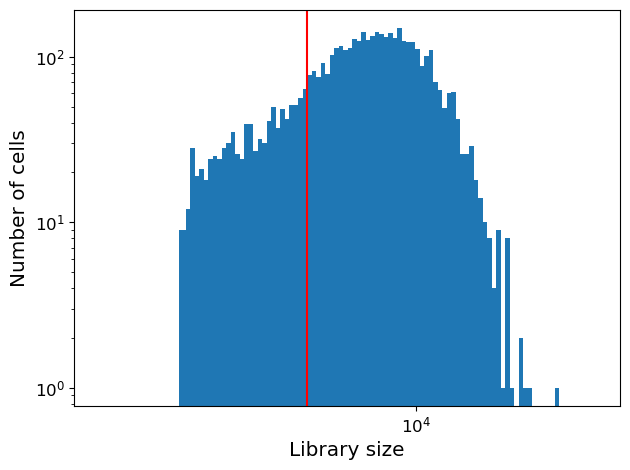

In [5]:
scprep.plot.plot_library_size(T1, percentile=20)
filtered_batches = []
for batch in [T1, T2, T3, T4, T5]:
    batch = scprep.filter.filter_library_size(batch, percentile=20, keep_cells='above')
    batch = scprep.filter.filter_library_size(batch, percentile=75, keep_cells='below')
    filtered_batches.append(batch)
del T1, T2, T3, T4, T5 # removes objects from memory


### Merge all datasets and create a vector representing the time point of each sample

In [6]:
EBT_counts, sample_labels = scprep.utils.combine_batches(filtered_batches, DAY_LABELS, append_to_cell_names=True)
# removes objects from memory
del filtered_batches 
EBT_counts.head()

A1BG (ENSG00000121410)  \
AAACATTGAAAGCA-1_Day 00-03                     0.0   
AAACCGTGCAGAAA-1_Day 00-03                     0.0   
AAACCGTGGAAGGC-1_Day 00-03                     0.0   
AAACGCACCGGTAT-1_Day 00-03                     0.0   
AAACGCACCTATTC-1_Day 00-03                     0.0   

                            A1BG-AS1 (ENSG00000268895)  \
AAACATTGAAAGCA-1_Day 00-03                         0.0   
AAACCGTGCAGAAA-1_Day 00-03                         0.0   
AAACCGTGGAAGGC-1_Day 00-03                         0.0   
AAACGCACCGGTAT-1_Day 00-03                         0.0   
AAACGCACCTATTC-1_Day 00-03                         0.0   

                            A1CF (ENSG00000148584)  A2M (ENSG00000175899)  \
AAACATTGAAAGCA-1_Day 00-03                     0.0                    0.0   
AAACCGTGCAGAAA-1_Day 00-03                     0.0                    0.0   
AAACCGTGGAAGGC-1_Day 00-03                     0.0                    0.0   
AAACGCACCGGTAT-1_Day 00-03                     0.0                    0.0   
AAACGCACCTATTC-1_Day 00-03                     0.0                    0.0   

                            A2M-AS1 (ENSG00000245105)  \
AAACATTGAAAGCA-1_Day 00-03                        0.0   
AAACCGTGCAGAAA-1_Day 00-03                        0.0   
AAACCGTGGAAGGC-1_Day 00-03                        0.0   
AAACGCACCGGTAT-1_Day 00-03                        0.0   
AAACGCACCTATTC-1_Day 00-03                        0.0   

                            A2ML1 (ENSG00000166535)  \
AAACATTGAAAGCA-1_Day 00-03                      0.0   
AAACCGTGCAGAAA-1_Day 00-03                      0.0   
AAACCGTGGAAGGC-1_Day 00-03                      0.0   
AAACGCACCGGTAT-1_Day 00-03                      0.0   
AAACGCACCTATTC-1_Day 00-03                      0.0   

                            A2ML1-AS1 (ENSG00000256661)  \
AAACATTGAAAGCA-1_Day 00-03                          0.0   
AAACCGTGCAGAAA-1_Day 00-03                          0.0   
AAACCGTGGAAGGC-1_Day 00-03                          0.0   
AAACGCACCGGTAT-1_Day 00-03                          0.0   
AAACGCACCTATTC-1_Day 00-03                          0.0   

                            A2ML1-AS2 (ENSG00000256904)  \
AAACATTGAAAGCA-1_Day 00-03                          0.0   
AAACCGTGCAGAAA-1_Day 00-03                          0.0   
AAACCGTGGAAGGC-1_Day 00-03                          0.0   
AAACGCACCGGTAT-1_Day 00-03                          0.0   
AAACGCACCTATTC-1_Day 00-03                          0.0   

                            A3GALT2 (ENSG00000184389)  \
AAACATTGAAAGCA-1_Day 00-03                        0.0   
AAACCGTGCAGAAA-1_Day 00-03                        0.0   
AAACCGTGGAAGGC-1_Day 00-03                        0.0   
AAACGCACCGGTAT-1_Day 00-03                        0.0   
AAACGCACCTATTC-1_Day 00-03                        0.0   

                            A4GALT (ENSG00000128274)  ...  \
AAACATTGAAAGCA-1_Day 00-03                       0.0  ...   
AAACCGTGCAGAAA-1_Day 00-03                       0.0  ...   
AAACCGTGGAAGGC-1_Day 00-03                       0.0  ...   
AAACGCACCGGTAT-1_Day 00-03                       0.0  ...   
AAACGCACCTATTC-1_Day 00-03                       0.0  ...   

                            ZXDC (ENSG00000070476)  ZYG11A (ENSG00000203995)  \
AAACATTGAAAGCA-1_Day 00-03                     0.0                       0.0   
AAACCGTGCAGAAA-1_Day 00-03                     0.0                       0.0   
AAACCGTGGAAGGC-1_Day 00-03                     0.0                       0.0   
AAACGCACCGGTAT-1_Day 00-03                     0.0                       0.0   
AAACGCACCTATTC-1_Day 00-03                     0.0                       0.0   

                            ZYG11B (ENSG00000162378)  ZYX (ENSG00000159840)  \
AAACATTGAAAGCA-1_Day 00-03                       0.0                    0.0   
AAACCGTGCAGAAA-1_Day 00-03                       0.0                    0.0   
AAACCGTGGAAGGC-1_Day 00-03                       0.0                    0.0   


### Preprocessing: Filtering, Normalizing, and Transforming

#### Filtering

We filter the data by: 
1. Filtering by library size (if we did not do this prior to combining batches)
2. Removing genes that are expressed in relatively few cells.
3. Removing dead cells

We filter dead cells after library size normalization, since library size is not necessarily related to cell state.

**Library size filtering**

We did this before, because the library size correlated strongly with our samples. However, if we wanted to do something simplier, we could have run the following here instead:

`EBT_counts, sample_labels = scprep.filter.library_size_filter(EBT_counts, sample_labels, cutoff=2000)`

**Remove rare genes**
We eliminate genes that are expressed in 10 cells or fewer.

In [7]:
EBT_counts = scprep.filter.filter_rare_genes(EBT_counts, min_cells=10)

#### Normalization

To correct for differences in library sizes, we divide each cell by its library size and then rescale by the median library size.

In python this is performed using the preprocessing method `library_size_normalize()`.

In [8]:
EBT_counts = scprep.normalize.library_size_normalize(EBT_counts)

#### Dead cell removal

Dead cells are likely to have a higher mitochondrial RNA expression level than live cells. Therefore, we remove suspected dead cells by eliminating cells that have the highest mitochondrial RNA expression levels on average.  

First let's look at the distribution of mitochontrial genes.

<Axes: xlabel='Gene expression', ylabel='Number of cells'>

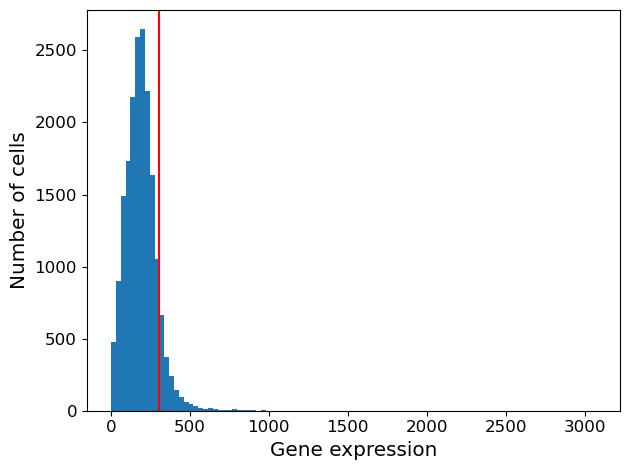

In [9]:
mito_genes = scprep.select.get_gene_set(EBT_counts, starts_with='MT-') # Get all mitochondrial genes. There are 14, FYI.
scprep.plot.plot_gene_set_expression(EBT_counts, genes=mito_genes, percentile=90)

Here we see that above the top 90th percentile, there is a steep increase in expression of mitochondrial RNAs. We'll remove these cells from further analysis.

In [10]:
EBT_counts, sample_labels = scprep.filter.filter_gene_set_expression(
    EBT_counts, sample_labels, genes=mito_genes, 
    percentile=90, keep_cells='below'
)

#### Transformation

In scRNA-seq analysis, the data is often $\log$-transformed. This typically requires the addition of some small value to avoid taking $\log(0)$. We avoid this issue entirely by instead taking the square root transform. The square root function has a similar form as the $\log$ function with the added benefit of being stable at 0.

In [11]:
EBT_counts = scprep.transform.sqrt(EBT_counts)

## Embed data using PHATE

**Instantiating the PHATE estimator**

The API of PHATE models that of Scikit Learn. First, you instantiate a PHATE estimator object with the parameters for fitting the PHATE embedding to a given dataset. Next, you use the `fit` and `fit_transform` functions to generate an embedding. For more information, check out [**the PHATE readthedocs page**](http://phate.readthedocs.io/).

We'll just use the default parameters for now, but the following parameters can be tuned (read our documentation at [phate.readthedocs.io](https://phate.readthedocs.io/) to learn more):

* `knn` : Number of nearest neighbors (default: 5). Increase this (e.g. to 20) if your PHATE embedding appears very disconnected. You should also consider increasing `knn` if your dataset is extremely large (e.g. >100k cells)
* `decay` : Alpha decay (default: 15). Decreasing `decay` increases connectivity on the graph, increasing `decay` decreases connectivity. This rarely needs to be tuned. Set it to `None` for a k-nearest neighbors kernel.
* `t` : Number of times to power the operator (default: 'auto'). This is equivalent to the amount of smoothing done to the data. It is chosen automatically by default, but you can increase it if your embedding lacks structure, or decrease it if the structure looks too compact.
* `gamma` : Informational distance constant (default: 1). `gamma=1` gives the PHATE log potential, but other informational distances can be interesting. If most of the points seem concentrated in one section of the plot, you can try `gamma=0`.

Since we are looking for subtle structure and we expect some of the trajectories to be sparse, we might want to decrease `knn` from the default of 5, and reduce `t` from the automatic value of 21 (printed in the output above). For single-cell RNA-seq you can try `knn` as low as 3 or 4 if you're looking for subtle structure, or as high as 30 or 40 if you have hundreds of thousands of cells. We'll also reduce `alpha` here to 15 to partially offset the decreased connectivity as a result of decreasing `knn`.

In [12]:
phate_op = phate.PHATE(n_jobs=-2, random_state=42)
Y_phate = phate_op.fit_transform(EBT_counts)

Calculating PHATE...
  Running PHATE on 16821 observations and 17845 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 19.36 seconds.
    Calculating KNN search...
    Calculated KNN search in 11.81 seconds.
    Calculating affinities...
    Calculated affinities in 0.82 seconds.
  Calculated graph and diffusion operator in 32.73 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 1.07 seconds.
    Calculating KMeans...
    Calculated KMeans in 2.34 seconds.
  Calculated landmark operator in 4.18 seconds.
  Calculating optimal t...
    Automatically selected t = 19
  Calculated optimal t in 0.95 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.26 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 3.43 seconds.
Calculated PHATE in 41.56 seconds.


### Save results

In [13]:
df_phate = pd.DataFrame(
    np.hstack((Y_phate, sample_labels.values.reshape(-1, 1))),
    index=EBT_counts.index,
    columns='P1 P2 samples'.split()
)

df_counts = EBT_counts.join(sample_labels).rename({'sample_labels': 'samples'}, axis=1)
df_counts.columns = df_counts.columns.map(lambda e: e.split(' ')[0])

In [14]:
df_counts.to_pickle(str(COUNTS_FILE))
df_phate.to_pickle(str(EMB_FILE))

with open(str(PHATE_FILE), 'wb') as f:
    pickle.dump(phate_op, f)

### Load data

In [15]:
with open(str(PHATE_FILE), 'rb') as f:
    phate_op = pickle.load(f)

In [16]:
# make PCA data more accesible and human friendly to read
pca_loadings = phate_op.graph.data_nu
pca_components = phate_op.graph.data_pca.components_

# create PCA DataFrame
df_pca = pd.DataFrame(
    pca_loadings, columns=[f'd{i}' for i in range(1, 101)],
)
df_pca.loc[:, 'samples'] = df_counts.samples.values

### Visualize ground truth data

In [17]:
if not FIGS_DIR.is_dir():
    FIGS_DIR.mkdir(exist_ok=True)

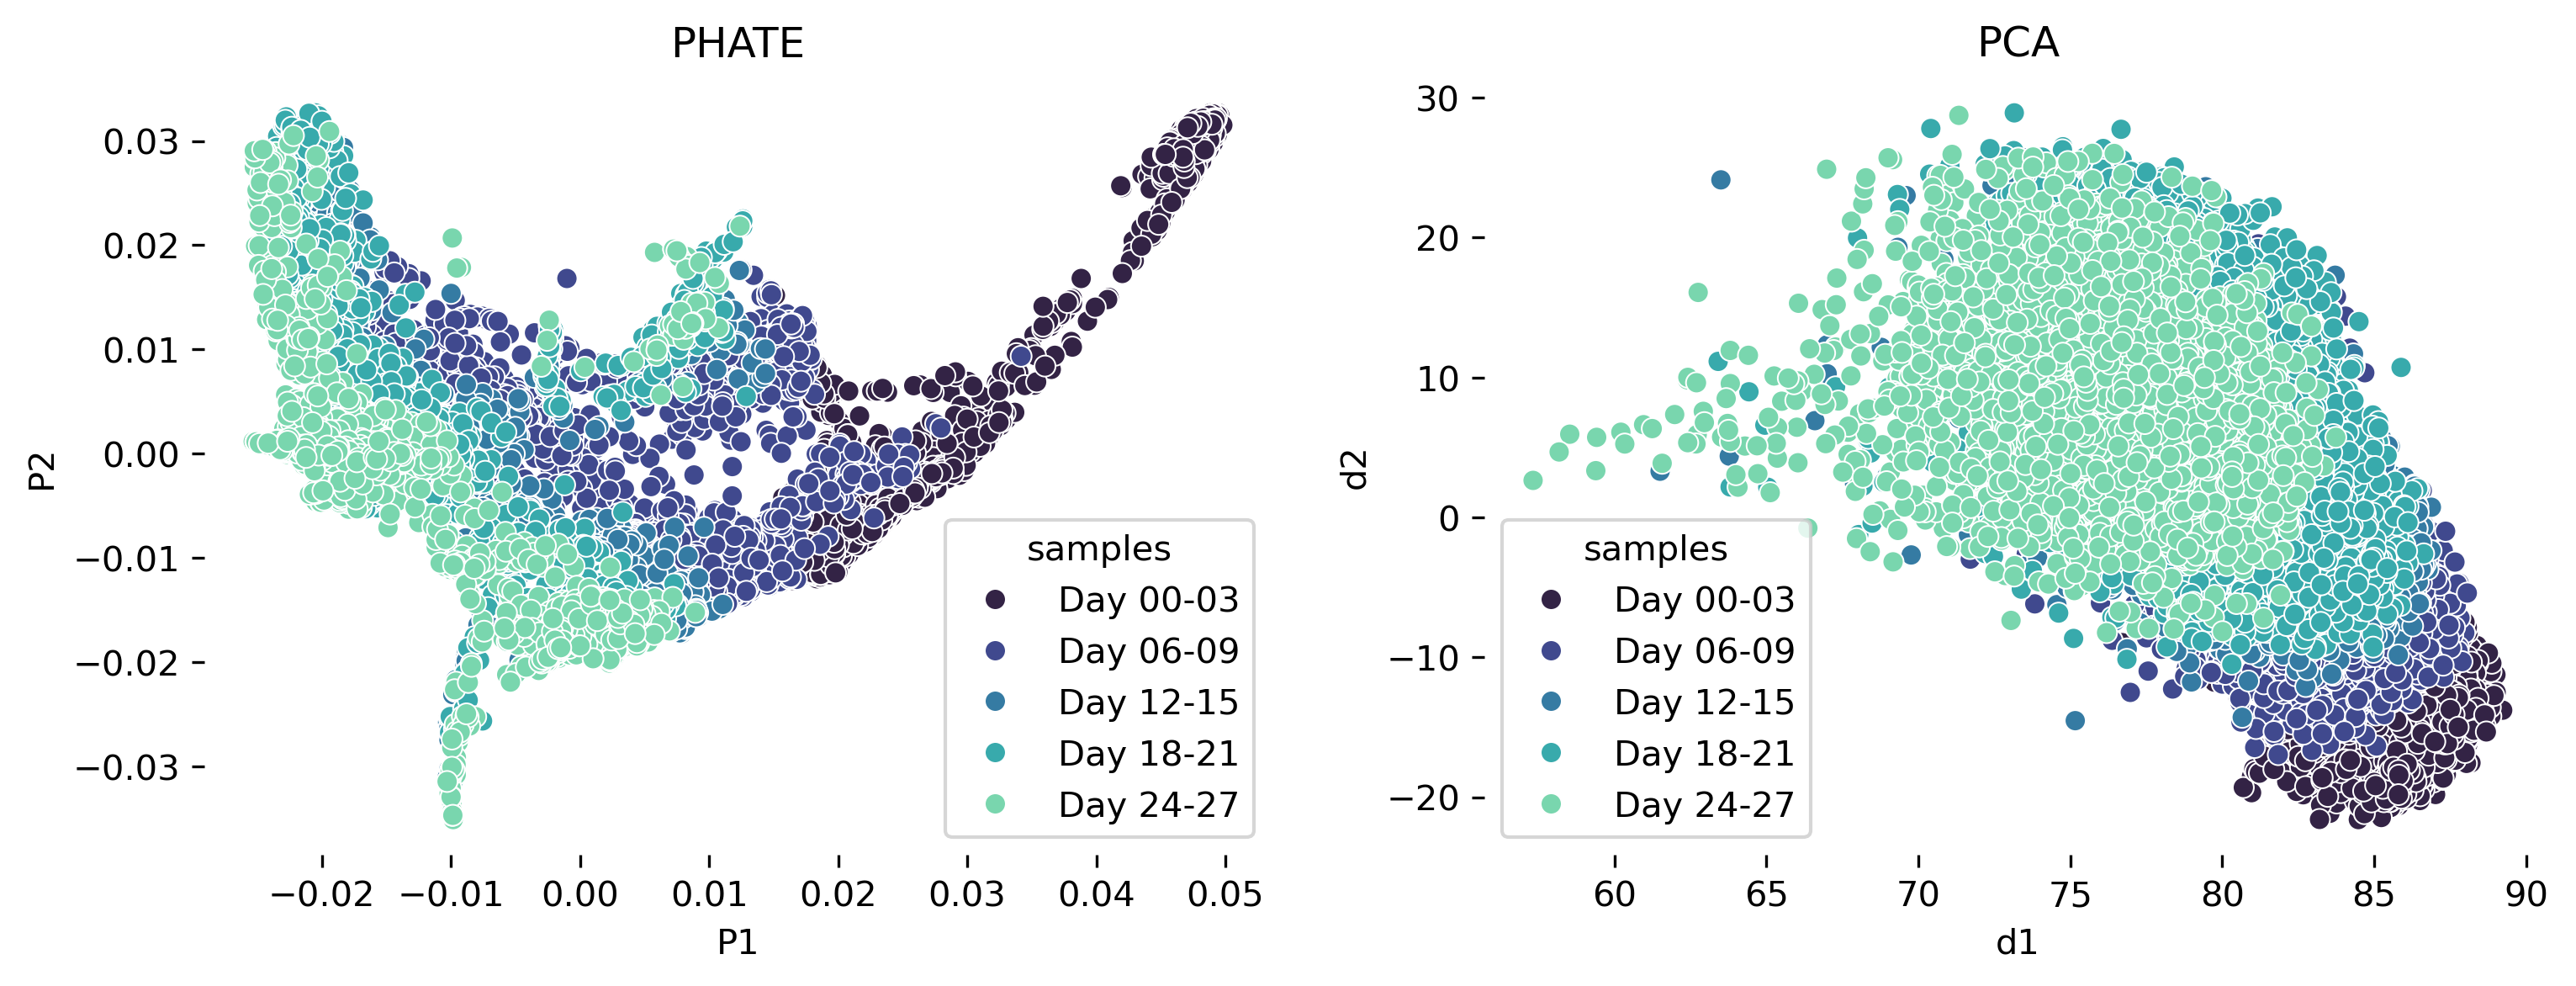

In [18]:
fig = plt.figure(figsize=(12, 4), dpi=300)

# plot PHATE
ax = fig.add_subplot(1, 2, 1)
ax.set_title('PHATE')
sns.scatterplot(df_phate, x='P1', y='P2', hue='samples', palette='mako', ax=ax)
sns.despine(offset=10, trim=True, left=True, bottom=True)


# plot PCA
ax = fig.add_subplot(1, 2, 2)
ax.set_title('PCA')
sns.scatterplot(df_pca, x='d1', y='d2', hue='samples', palette='mako')
sns.despine(trim=True, left=True, bottom=True)

fig.savefig(str(FIGS_DIR / 'embedding.png'))

In [19]:
df_counts.head()

A1BG  A1BG-AS1  A2M  A2M-AS1  A2ML1  A4GALT  AAAS  \
AAACCGTGCAGAAA-1_Day 00-03   0.0       0.0  0.0      0.0    0.0     0.0   0.0   
AAACGCACCGGTAT-1_Day 00-03   0.0       0.0  0.0      0.0    0.0     0.0   0.0   
AAACGCACCTATTC-1_Day 00-03   0.0       0.0  0.0      0.0    0.0     0.0   0.0   
AAAGATCTCTGCTC-1_Day 00-03   0.0       0.0  0.0      0.0    0.0     0.0   0.0   
AAAGATCTGGTACT-1_Day 00-03   0.0       0.0  0.0      0.0    0.0     0.0   0.0   

                            AACS  AADAT  AAED1  ...     ZWINT  ZXDA  ZXDB  \
AAACCGTGCAGAAA-1_Day 00-03   0.0    0.0    0.0  ...  0.000000   0.0   0.0   
AAACGCACCGGTAT-1_Day 00-03   0.0    0.0    0.0  ...  0.000000   0.0   0.0   
AAACGCACCTATTC-1_Day 00-03   0.0    0.0    0.0  ...  1.112210   0.0   0.0   
AAAGATCTCTGCTC-1_Day 00-03   0.0    0.0    0.0  ...  1.352958   0.0   0.0   
AAAGATCTGGTACT-1_Day 00-03   0.0    0.0    0.0  ...  0.000000   0.0   0.0   

                            ZXDC  ZYG11A  ZYG11B      ZYX  ZZEF1  ZZZ3  \
AAACCGTGCAGAAA-1_Day 00-03   0.0     0.0     0.0  0.00000    0.0   0.0   
AAACGCACCGGTAT-1_Day 00-03   0.0     0.0     0.0  0.00000    0.0   0.0   
AAACGCACCTATTC-1_Day 00-03   0.0     0.0     0.0  1.11221    0.0   0.0   
AAAGATCTCTGCTC-1_Day 00-03   0.0     0.0     0.0  0.00000    0.0   0.0   
AAAGATCTGGTACT-1_Day 00-03   0.0     0.0     0.0  0.00000    0.0   0.0   

                              samples  
AAACCGTGCAGAAA-1_Day 00-03  Day 00-03  
AAACGCACCGGTAT-1_Day 00-03  Day 00-03  
AAACGCACCTATTC-1_Day 00-03  Day 00-03  
AAAGATCTCTGCTC-1_Day 00-03  Day 00-03  
AAAGATCTGGTACT-1_Day 00-03  Day 00-03  

[5 rows x 17846 columns]

<hr style="border-width: 0.8px">
<div style="text-align:left;">
    <h4>Implementing a Neural ODE with <kbd>torchdyn</kbd></h4>
</div>

## Prepare for training

### Load data

In [20]:
# load counts DataFrame
df_counts = pd.read_pickle(str(COUNTS_FILE))

# load PHATE DataFrame
df_phate = pd.read_pickle(str(EMB_FILE))

# load phate_op to get PCA information
with open(str(PHATE_FILE), 'rb') as f:
    phate_op = pickle.load(f)

# make PCA data more accesible and human friendly to read
pca_loadings = phate_op.graph.data_nu
pca_components = phate_op.graph.data_pca.components_

# create PCA DataFrame
df_pca = pd.DataFrame(
    pca_loadings, columns=[f'd{i}' for i in range(1, 101)],
)
df_pca.loc[:, 'samples'] = df_counts.samples.values

### Visualize ground truth data

In [21]:
if not FIGS_DIR.is_dir():
    FIGS_DIR.mkdir(exist_ok=True)

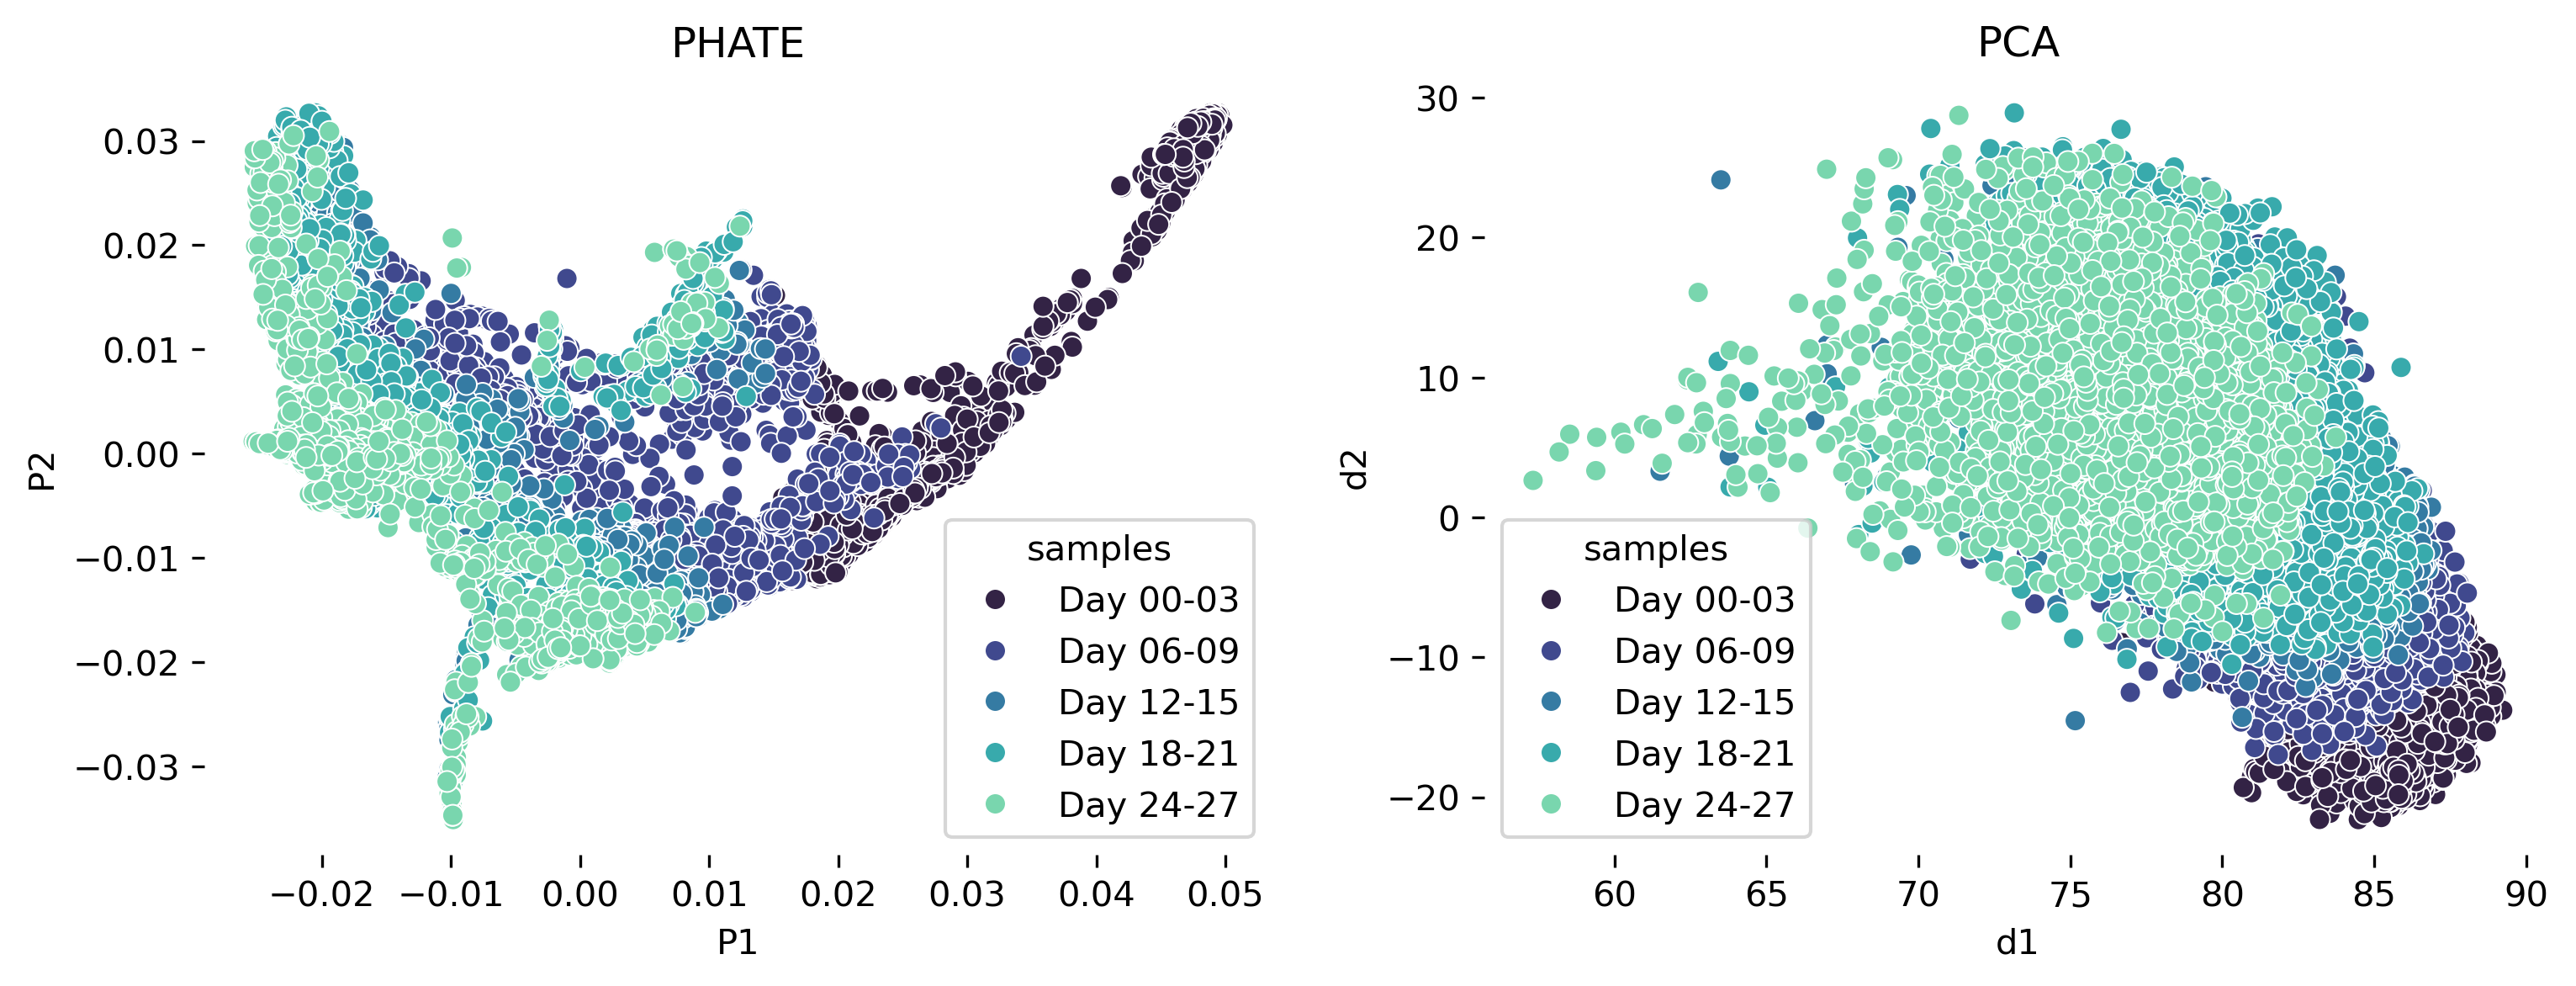

In [22]:
fig = plt.figure(figsize=(12, 4), dpi=300)

# plot PHATE
ax = fig.add_subplot(1, 2, 1)
ax.set_title('PHATE')
sns.scatterplot(df_phate, x='P1', y='P2', hue='samples', palette='mako', ax=ax)
sns.despine(offset=10, trim=True, left=True, bottom=True)


# plot PCA
ax = fig.add_subplot(1, 2, 2)
ax.set_title('PCA')
sns.scatterplot(df_pca, x='d1', y='d2', hue='samples', palette='mako')
sns.despine(trim=True, left=True, bottom=True)

fig.savefig('figures/embedding.png')

In [23]:
df_counts.head()

A1BG  A1BG-AS1  A2M  A2M-AS1  A2ML1  A4GALT  AAAS  \
AAACCGTGCAGAAA-1_Day 00-03   0.0       0.0  0.0      0.0    0.0     0.0   0.0   
AAACGCACCGGTAT-1_Day 00-03   0.0       0.0  0.0      0.0    0.0     0.0   0.0   
AAACGCACCTATTC-1_Day 00-03   0.0       0.0  0.0      0.0    0.0     0.0   0.0   
AAAGATCTCTGCTC-1_Day 00-03   0.0       0.0  0.0      0.0    0.0     0.0   0.0   
AAAGATCTGGTACT-1_Day 00-03   0.0       0.0  0.0      0.0    0.0     0.0   0.0   

                            AACS  AADAT  AAED1  ...     ZWINT  ZXDA  ZXDB  \
AAACCGTGCAGAAA-1_Day 00-03   0.0    0.0    0.0  ...  0.000000   0.0   0.0   
AAACGCACCGGTAT-1_Day 00-03   0.0    0.0    0.0  ...  0.000000   0.0   0.0   
AAACGCACCTATTC-1_Day 00-03   0.0    0.0    0.0  ...  1.112210   0.0   0.0   
AAAGATCTCTGCTC-1_Day 00-03   0.0    0.0    0.0  ...  1.352958   0.0   0.0   
AAAGATCTGGTACT-1_Day 00-03   0.0    0.0    0.0  ...  0.000000   0.0   0.0   

                            ZXDC  ZYG11A  ZYG11B      ZYX  ZZEF1  ZZZ3  \
AAACCGTGCAGAAA-1_Day 00-03   0.0     0.0     0.0  0.00000    0.0   0.0   
AAACGCACCGGTAT-1_Day 00-03   0.0     0.0     0.0  0.00000    0.0   0.0   
AAACGCACCTATTC-1_Day 00-03   0.0     0.0     0.0  1.11221    0.0   0.0   
AAAGATCTCTGCTC-1_Day 00-03   0.0     0.0     0.0  0.00000    0.0   0.0   
AAAGATCTGGTACT-1_Day 00-03   0.0     0.0     0.0  0.00000    0.0   0.0   

                              samples  
AAACCGTGCAGAAA-1_Day 00-03  Day 00-03  
AAACGCACCGGTAT-1_Day 00-03  Day 00-03  
AAACGCACCTATTC-1_Day 00-03  Day 00-03  
AAAGATCTCTGCTC-1_Day 00-03  Day 00-03  
AAAGATCTGGTACT-1_Day 00-03  Day 00-03  

[5 rows x 17846 columns]

## Define custom dataset

From the [PyTorch](https://pytorch.org/) documentation regarding how [create a custom Dataset for your files](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files)
>  A custom Dataset class must implement three functions: __init__, __len__, and __getitem__. 

Below we create a custom dataset `CellDataset` to make handling our data easier.

In [24]:
class CellDataset(Dataset):
    def __init__(self, df: pd.DataFrame, time_key: str = 'samples', scale_x: bool=True):        
        self.df = df
        self.time_key = time_key
        self.scale_x = scale_x
        
        time_categories = df[time_key].astype('category')
        time_categories = time_categories.cat.codes
        unique_timepoints = sorted(time_categories.unique())
        
        # scale X
        X = df.drop(columns=time_key).values        
        scaler = StandardScaler()
        scaler = scaler.fit(X)
        if scale_x:
            X = scaler.transform(X)

        # Just the data from our DataFrame, normalized
        self.X = X        
        
        # Just the time labels from our DataFrame mapped to integers
        self.y = time_categories

        self.scaler = scaler
        
    @property
    def n_genes(self):
        try:
            return self._n_genes
        except AttributeError:
            self._n_genes = self.X.shape[1]
            return self._n_genes
        
    @property
    def n_cells(self):
        try:
            return self._n_cells
        except AttributeError:
            self._n_cells = self.X.shape[0]
            return self._n_cells

    def __len__(self):        
        return int(len(self.X))

    def __getitem__(self, idx):
        x = torch.Tensor(self.X[idx]).to(device).to(torch.float32)
        y = self.y[idx]
        return x, y
    
    def invert(self, X=None):
        if X is None:
            X = self.X
        if not self.scale_x:
            return X
        return self.scaler.inverse_transform(X)

## Define utility variables

### Dataset related variables

**NOTE** we set some important variables here including:
- `batch_size`: number of cellular _trajectories_ to use per batch
- `perc_split`: percentage of full dataset to use as training data

In [25]:
# how many PCs to use
n_pcs = 100
df_pca = df_pca.loc[:, ['samples']+[f'd{i}' for i in range(1, n_pcs+1)]]

# aka num rows in df_counts
num_cells = df_counts.shape[0]

# aka num cols in df_counts
num_genes = df_counts.shape[1] - 1 # last column is samples

# aka num cols in df_counts
num_pca = df_pca.shape[1] - 1

# split percentage for train / validation
perc_split = 90

n_train = int(perc_split / 100 * num_cells)
n_valid = num_cells - n_train

batch_size = 8

# whether or not to use df_counts or df_pca
# NOTE: for this problem we are training in PCA space
use_counts = False

n_dims = (num_genes if use_counts else num_pca)
df = (df_counts if use_counts else df_pca)

### Instantiate dataset

Below we create the actual training and validation sets and the corresponding `DataLoader`s. You should iterate over them to check the shape of the data they yield.
Also note how this _may_ have a difference shape in comparison to the output of your `NeuralODE` i.e.

```python
for batch in my_dataloader:
    break
print(batch.shape)
```

In [26]:
# Split our data into training and validation sets
train_set, valid_set = torch.utils.data.random_split(
    df.drop(columns='samples').values,
    [n_train, n_valid]
)

# Create our TimeDataset objects for training and validation data
train_ds = CellDataset(df.iloc[train_set.indices].reset_index(drop=True))
valid_ds = CellDataset(df.iloc[valid_set.indices].reset_index(drop=True))

# Create our DataLoaders for the training and validation data
train_loader = DataLoader(
    train_ds, batch_size=batch_size, 
    shuffle=True, drop_last=True
)

valid_loader =DataLoader(
    valid_ds, batch_size=batch_size, 
    shuffle=True, drop_last=True
)

## Create a basic neural network

This network is the _function_ that our Neural ODE will use to predict the next timepoint.

In [27]:
class FlowNet(nn.Module):
    def __init__(self, activation='CELU'):
        super().__init__()
        act_fn = getattr(nn, activation)
        
        self.act_fn = act_fn
        
        self.seq = nn.Sequential(
            nn.Linear(n_dims,          n_dims),
            act_fn(),

            nn.Linear(n_dims,          int(n_dims / 2)),
            act_fn(),
            
            nn.Linear(int(n_dims / 2), int(n_dims / 4)),
            act_fn(),
            
            nn.Linear(int(n_dims / 4), int(n_dims / 2)),
            act_fn(),
            
            nn.Linear(int(n_dims / 2), n_dims),
            act_fn(),

            nn.Linear(n_dims,          n_dims),
        )

    def forward(self, x):
        return self.seq(x).to(device)

## Define your loss

**TODOs**:
- implement your own class for your network's loss

    + you may use [TorchDyn](https://torchdyn.org)

    + recall that: 
    $$
    \log{p_{t_1}}(x_{t_1}) = \log{p_{t_0}}(x_{t_0}) - \int_{t_0}^{t_1}\texttt{Tr}{\left(\frac{\delta f}{\delta x (t)}\right)} dt
    $$

    + HINT: you may find [Chen et al 2018][chen2018node] useful

    [chen2018node]: https://arxiv.org/pdf/1806.07366.pdf
    

In [75]:
class NegativeLogLikelihood(nn.Module):    
    def __init__(self, model:nn.Module):
        super().__init__()
        self.model = model    

    def __call__(self, X: torch.Tensor, prior):          
        t_eval, trace_jacobian = self.model(X)

        # TODO: define your loss here
        # logp(z_S) = logp(z_0) - \int_0^S trJ

        # ignore
        # logp_z0 = prior.log_prob(x)
        # j_sum = trace_jacobian.sum(dim=0)
        # j_sum = j_sum.sum(dim=1)
        # logp_zS = logp_z0 - j_sum

        # take mean??
        
        # HINT: https://pytorch.org/docs/stable/distributions.html#multinomial has a function called log_prob
        
        # splice jacobian trace and calculate log probability
        lps = prior.log_prob(trace_jacobian[1, :, 1:])
        
        # convert back to tensor for arithmetic
        lps = lps.to(X)
        
        # 0 trace jacobian
        trj0 = trace_jacobian[1, :, 0]
        
        # mean of calculation
        loss = torch.mean(lps - trj0)
        loss = -loss # negate

        return loss

## Defined PyLightning trainer

**TODOs**:

- add your `MaximumLikelihood` loss to the trainer    

- implement `training_step`

In [76]:
class Learner(LightningModule):
    def __init__(
        self, 
        model: nn.Module,        
        train_loader: DataLoader
    ):
        super().__init__()
        
        # NOTE: model here is the Neural ODE
        self.model = model.to(device)
        
        # The steps to integrate over
        self.t_span = torch.arange(0, 10, 1).to(device).to(torch.float32)
        
        # Our dataset
        self.train_loader = train_loader
        
        # The distribution from which we are sampling to generate points
        self.prior = torch.distributions.normal.Normal(loc=0.0, scale=1.0)
        self.prior = torch.distributions.MultivariateNormal(torch.zeros(n_dims), torch.eye(n_dims))
        

        # TODO: set your loss function here
        # self.loss = your loss here
        self.loss = NegativeLogLikelihood(self.model) # call loss that we just defined

    @property
    def n_features(self):
        return self.train_dataloader().dataset.n_genes
    
    def train_dataloader(self):
        return self.train_loader
    
    def sample(self, shape):
        z = self.prior.sample(sample_shape=shape).to(torch.float32)
        return z.to(device)
        
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):        
        cells, times = batch 
        # TODO: handle your training step here
        
        # model is called in loss function
        # will be called when we calculate loss
        
        # pass in cells and prior distribution for log prob calc
        loss = self.loss(cells, self.prior)

        # log and return loss
        self.log('loss', loss, prog_bar=True)
        return {'loss': loss}  
        
    @torch.no_grad()
    def generate_cells(self, n_cells):
        # NOTE: this assumes that `self.model` is an `nn.Sequential`
        #       where the second element is a TorchDyn `NeuralODE`
        
        # this is aligned with our defined model (augmenter, neuralODE using cnf)

        z = self.sample(torch.Size([n_cells]))
        
        # integrating from 1 to 0
        self.model[1].t_span = torch.linspace(1, 0, 2)

        t_eval, z_to_cells = self.model(z)
        new_cells = z_to_cells[-1]
        new_cells = new_cells[:, 1:]

        return new_cells

    def sample_cells(self, n_cells):
        gen_cells = self.generate_cells(n_cells)        
        df_pred = pd.DataFrame(
            gen_cells.clone().detach().cpu().numpy(),            
            columns = [
                f'd{i}' for i in range(1, (self.n_features)+1)
            ]
        )
        return df_pred
    
    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.model.parameters(), lr=0.001, weight_decay=1e-5)
        scheduler = optim.lr_scheduler.StepLR(optimizer, 100, gamma=0.99)
        return [optimizer], [scheduler]

## Create your NeuralODE model

**TODOs**:

- train a neural ODE with your model

    + you may use [TorchDyn](https://torchdyn.org)

    + HINT: you may find `torchdyn.nn.Augmenter` and `torchdyn.models.CNF` useful

In [77]:
flow = FlowNet()

# TODO: implement neural ODE
# model = your_neural_ode(flow, ...)
# model = ...

# notes
# we want to apply cnf on the flow
# we know flow is an input to the neuralode
# can modify flow input to be processed thru cnf
# class specifies construction of nn.Sequential with augmenter and 2nd element NeuralODE

model = nn.Sequential(
    Augmenter(augment_idx=1, augment_dims=1),
    NeuralODE(CNF(flow), solver='dopri5', atol=1e-4, rtol=1e-4, sensitivity='adjoint'))


Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.


## Initalize trainer

In [78]:
# create our PyLightning learner to handle training steps
learn = Learner(model, train_loader)
learn = learn.to(device)

In [79]:
max_time = dict(minutes=10) 

# create our PyLightning trainer to actualy train the model
trainer = Trainer(
    max_epochs=10,
    
    # NOTE: gradient clipping can help prevent exploding gradients
    gradient_clip_val=100,
    gradient_clip_algorithm='value',    
    log_every_n_steps=5,
    
    # NOTE: this should match your device i.e. if you set cuda above, this should be cuda. 
    # Otherwise it should be cpu. 
    accelerator=DEVICE_NAME,    
    
    # NOTE: you can set the maximum time you want to train your model
    max_time=max_time,

    # NOTE: setting this to true will save your model every so often
    enable_checkpointing=False,
    accumulate_grad_batches=2
)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


### Train model

In [80]:
trainer.fit(learn)


  | Name  | Type                  | Params
------------------------------------------------
0 | model | Sequential            | 32.9 K
1 | loss  | NegativeLogLikelihood | 32.9 K
------------------------------------------------
32.9 K    Trainable params
0         Non-trainable params
32.9 K    Total params
0.132     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

Time limit reached. Elapsed time is 0:10:00. Signaling Trainer to stop.


### Save model

In [81]:
if not MODELS_DIR.is_dir():
    MODELS_DIR.mkdir(exist_ok=True)

In [82]:
torch.save(model, str(MODEL_FILE))
torch.save(model.state_dict(), str(STATE_FILE))

## Visualize generated cells in PCA space

In [83]:
learn.to(device)

Learner(
  (model): Sequential(
    (0): Augmenter()
    (1): Neural ODE:
    	- order: 1        
    	- solver: DormandPrince45()
    	- adjoint solver: DormandPrince45()        
    	- tolerances: relative 0.0001 absolute 0.0001        
    	- adjoint tolerances: relative 0.0001 absolute 0.0001        
    	- num_parameters: 32925        
    	- NFE: 18570.0
  )
  (loss): NegativeLogLikelihood(
    (model): Sequential(
      (0): Augmenter()
      (1): Neural ODE:
      	- order: 1        
      	- solver: DormandPrince45()
      	- adjoint solver: DormandPrince45()        
      	- tolerances: relative 0.0001 absolute 0.0001        
      	- adjoint tolerances: relative 0.0001 absolute 0.0001        
      	- num_parameters: 32925        
      	- NFE: 18570.0
    )
  )
)

In [84]:
num_generate = 1000

# Generate cells as a pandas DataFrame
df_pred = learn.sample_cells(num_generate)

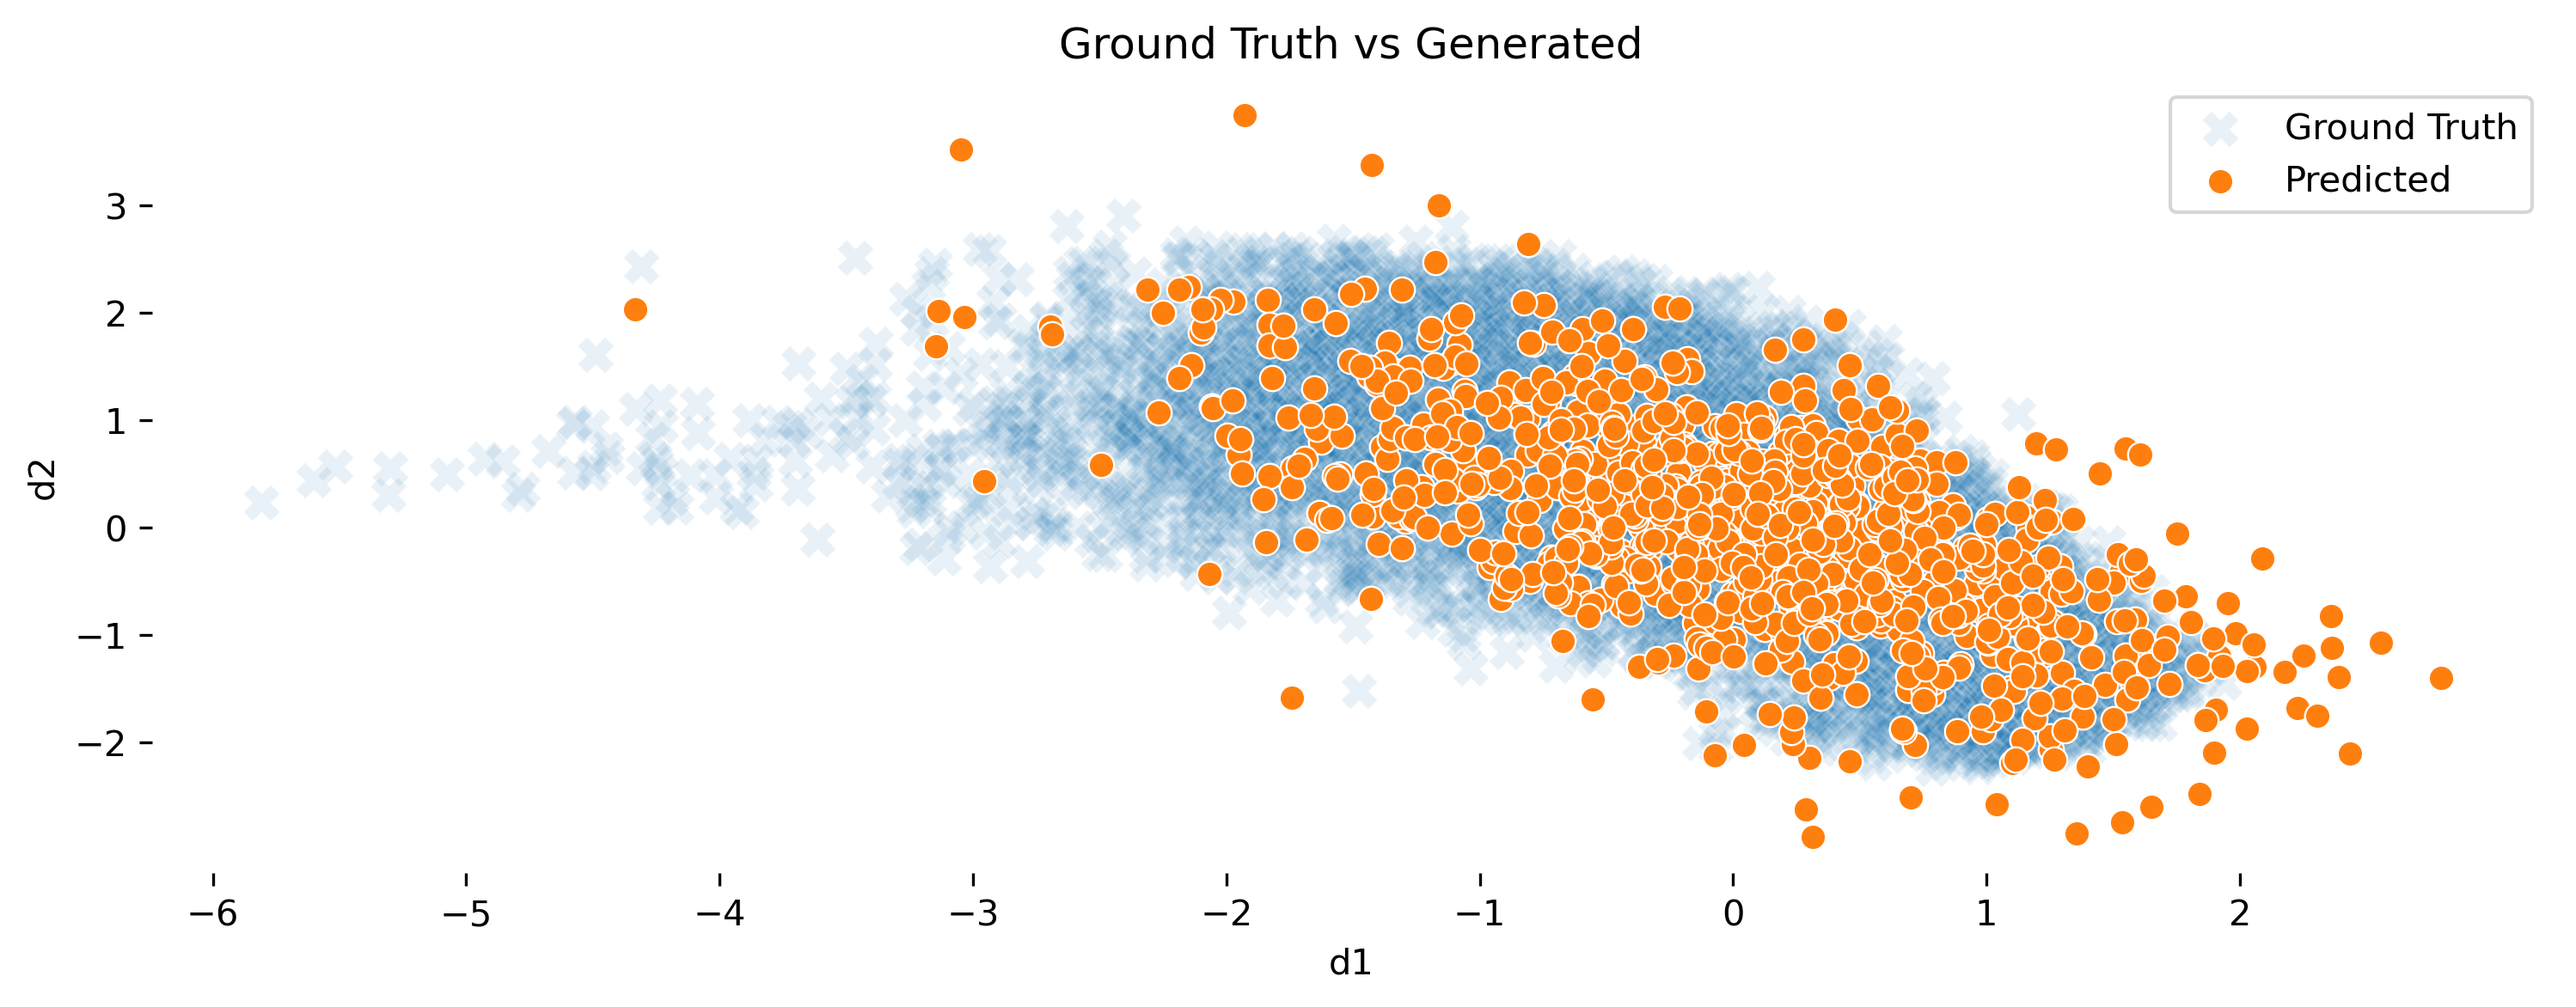

In [85]:
fig = plt.figure(figsize=(12, 4), dpi=300)
ax = fig.add_subplot(1, 1, 1)
ax.set_title('Ground Truth vs Generated')
sns.scatterplot(
    # df_pca, 
    pd.DataFrame(train_ds.X, columns=[f'd{i}' for i in range(1, n_pcs+1)]),
    x='d1', y='d2', 
    palette='mako', 
    ax=ax, marker='X', alpha=0.1, s=100, 
    label='Ground Truth'
)
sns.despine(trim=True, left=True, bottom=True)
sns.scatterplot(
    df_pred, 
    x='d1', y='d2', 
    palette='mako',
    ax=ax, marker='o', alpha=1, s=50,
    label='Predicted'
)
sns.despine(trim=True, left=True, bottom=True)
fig.savefig('figures/unregularized_model_latent_space.png')

## Invert generated cells from PCA space to gene space 

We trained our model on the first 100 principal components.

**TODOs**: 

- Take a moment and reflect why are some reasons why this might be desirable?

    + since we only use first 100 PCAs (denoised data) inverting back to gene space helps with data generation

    + since we are flowing from a n-dimensional gaussian to our n-feature data, running in the 10k+ gene space is not performant 

- Invert your generated cells back to gene space

    + hint: you can use the PCA components and PCA loadings stored in the PHATE operator

In [86]:
# TODO: invert generated cells back to gene space
# generated_cells = ...

# execute inversion
# required n_pc to be 100 instead of 10, so change was made above
generated_cells = phate_op.graph.data_pca.inverse_transform(df_pred)

# display
print(generated_cells)

[[ 0.00062471  0.00431424 -0.00593062 ...  0.0959368   0.00496122
  -0.01061288]
 [ 0.03874811  0.00709738  0.01524529 ...  0.03119094  0.00110053
   0.01043025]
 [-0.02831272 -0.00443012 -0.00341192 ... -0.00663098  0.0093563
   0.00058363]
 ...
 [ 0.03226191  0.00871595 -0.01102339 ... -0.02371223  0.01407747
   0.01203099]
 [ 0.04595817  0.0063991  -0.00620415 ... -0.05471625  0.00365978
   0.00364354]
 [ 0.02559233 -0.00840268  0.00745903 ... -0.00892964  0.00199238
   0.01199548]]


## Visualize expression of generated cells

While visualizing your generated cells in PCA space helps easily identify if your model is learning or not, it is hard to tell if these cells actually "look" like cells.
To better evaluate your generated cells, visualize the distribution of gene expression of your generated cells vs the real cells.

**TODOS**

- produce following figure:

    - distribution of gene expressed at each t for generated data vs ground truth data with the OT loss labeled in each subplot

        + can be 5 **sub**plots each with 2 curves / histograms

        + can be 10 **sub**plots (2 rows of 5) with one row for generated and one row for ground truth

**HINT**: try using [Seaborn](https://seaborn.pydata.org/)'s [FacetGrid](https://seaborn.pydata.org/generated/seaborn.FacetGrid.html)

### Just marker genes

In [87]:
df_counts.columns = df_counts.columns.map(lambda e: e.split(' ')[0])
known_genes = df_counts.columns.values.tolist()

marker_genes = 'PDGFRA HAND1 SOX17 ONECUT2 NANOG TNNT2'.split()
marker_genes = [gene for gene in marker_genes if gene in known_genes]
marker_idxs = [known_genes.index(gene) for gene in marker_genes]
markers = dict(zip(marker_genes, marker_idxs))
markers

{'PDGFRA': 10323,
 'HAND1': 6265,
 'SOX17': 14663,
 'ONECUT2': 9940,
 'NANOG': 9254,
 'TNNT2': 15948}

In [88]:
# storage variable
expression_data = []

# append entries for predicted cells
for idx, record in enumerate(generated_cells):
    for gene, col in markers.items():        
        expression_data.append({
            'type': 'generated',
            'expression': record[col],
            'gene': gene,
        })


# append entires for ground truth cells
df_sampled = df_counts.sample(num_generate)
ground_truth_cells = df_sampled.drop(columns='samples').values
for idx, record in enumerate(ground_truth_cells):
    for gene, col in markers.items():
        expression_data.append({
            'type': 'ground_truth',
            'expression': record[col],
            'gene': gene,
        })

# conver to DataFrame
df_expr = pd.DataFrame(expression_data)
df_expr.head()

type  expression     gene
0  generated   -0.023252   PDGFRA
1  generated   -0.598899    HAND1
2  generated    0.266443    SOX17
3  generated    0.003972  ONECUT2
4  generated    0.014426    NANOG

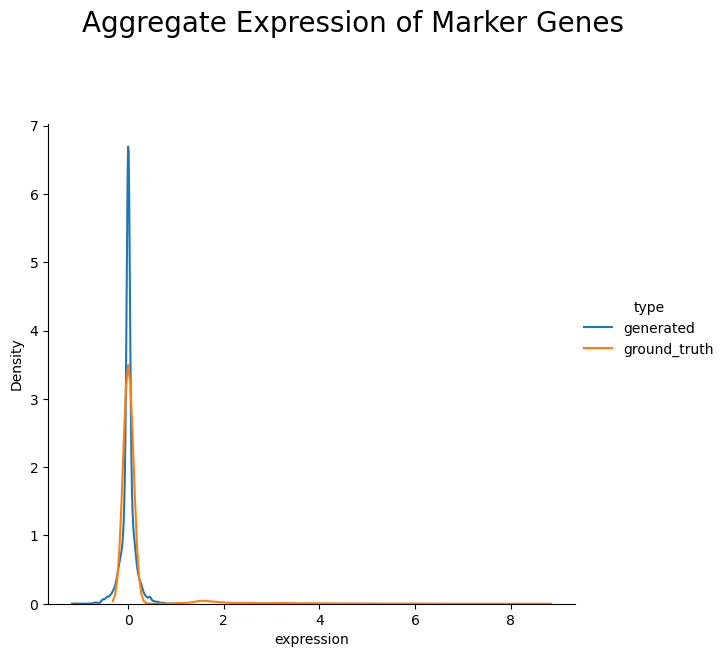

In [89]:
g = sns.FacetGrid(
    df_expr,
    hue='type', sharey=False, sharex=False,
    despine=True, height=3, aspect=4/2, 
)
g.map(sns.kdeplot, "expression")
g.add_legend()
g.fig.subplots_adjust(top=0.6, bottom=-1)
g.fig.suptitle('Aggregate Expression of Marker Genes', fontsize=20);
g.savefig('figures/agg_marker_gene_expression.png', dpi=300)

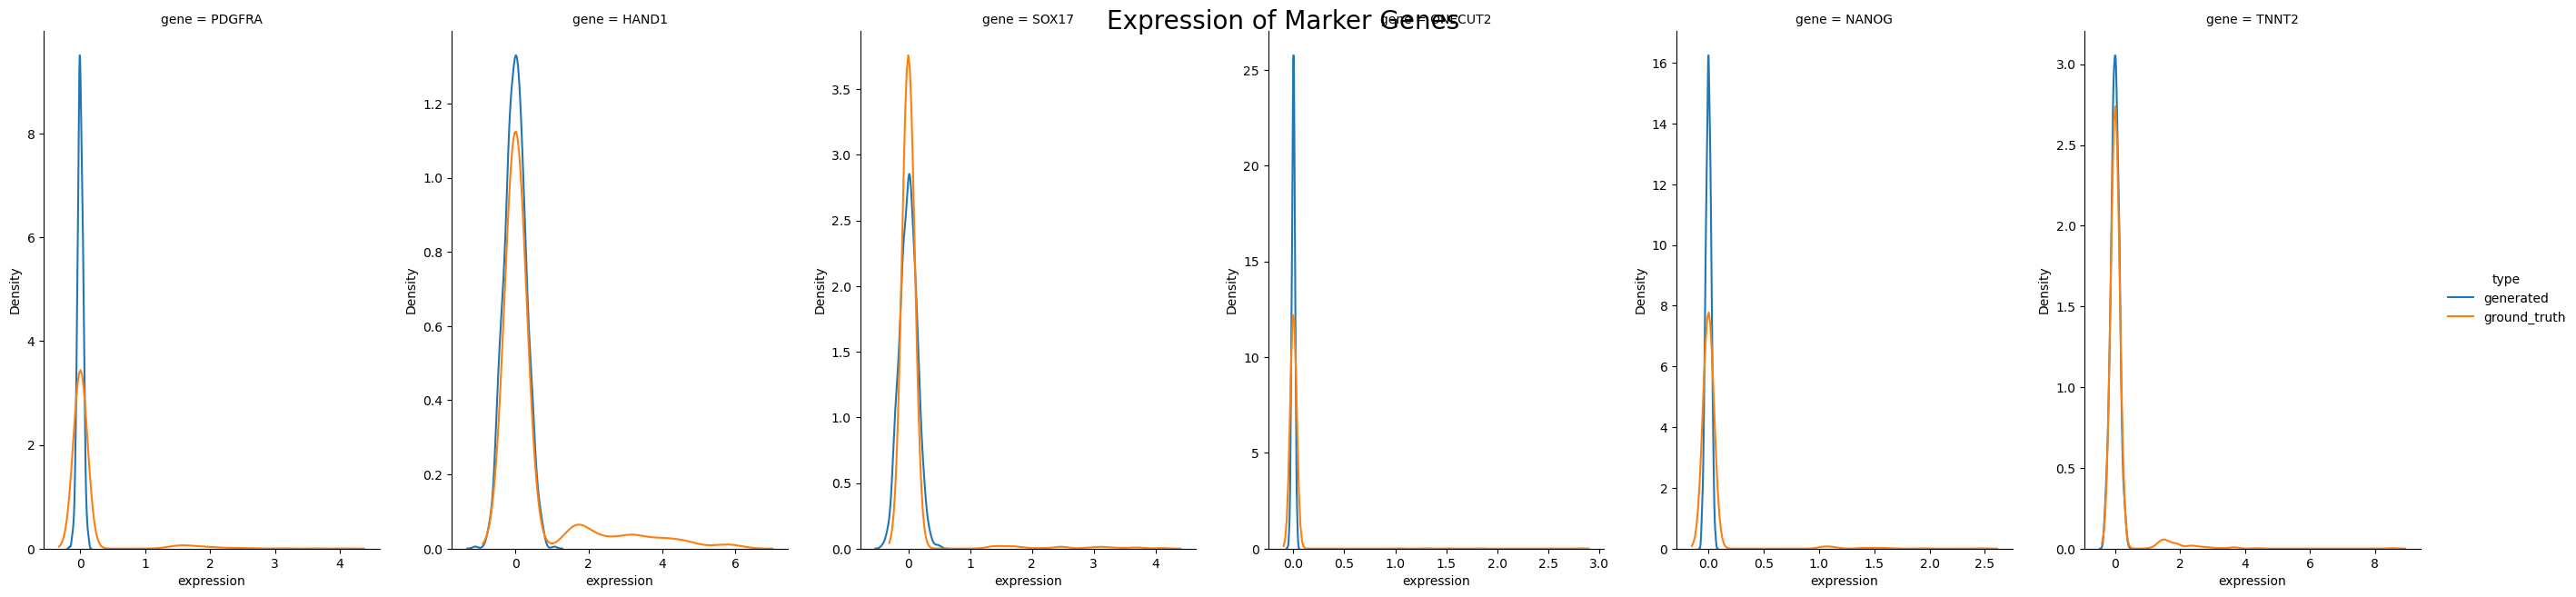

In [90]:
g = sns.FacetGrid(
    df_expr, col='gene',
    hue='type', sharey=False, sharex=False,
    despine=True, height=3, aspect=1.5 
)
g.map(sns.kdeplot, "expression", warn_singular=False)
g.add_legend()
g.fig.subplots_adjust(top=0.9, bottom=-1)
g.fig.suptitle('Expression of Marker Genes', fontsize=20)
g.savefig('figures/marker_gene_expression.png', dpi=300)

## Model improvements

**TODOs**:
- add magnitude regularization to try and improve your data generation
    
    + recall that this surmounts to in essence the squared norm: $$||f||^2$$

        - HINT: you may find it useful to concatenate a feature to your input to keep track of this

    + what metrics did you use to determine whether or not your regularization improved the quality of your data generation?
    
- produce the previous figures for your regularized model i.e.

    + a plot showing your cells in the latent space compared to real cells

    + a plot comparing expression of genes in you generated cells vs real cells

In [54]:
class RegularizedNegativeLogLikelihood(nn.Module):    
    def __init__(self, model:nn.Module):
        super().__init__()
        self.model = model    

    def __call__(self, X: torch.Tensor, prior):          
        t_eval, trace_jacobian = self.model(X)

        # TODO: define your loss here
        # logp(z_S) = logp(z_0) - \int_0^S trJ
        
        # HINT: https://pytorch.org/docs/stable/distributions.html#multinomial has a function called log_prob
        
        # splice jacobian trace and calculate log probability
        lps = prior.log_prob(trace_jacobian[1, :, 1:])
        
        # convert back to tensor for arithmetic
        lps = lps.to(X)
        
        # 0 trace jacobian
        trj0 = trace_jacobian[1, :, 0]
        
        # mean of calculation
        loss = torch.mean(lps - trj0)
        loss = -loss # negate
        
        # Calculate L2 regularization term
        l2_regularization = 0.0
        for param in self.model.parameters():
            l2_regularization += torch.norm(param, p=2)  # L2 norm of parameters
        
        # Add regularization term to the loss
        loss += 0.6 * l2_regularization

        return loss

In [55]:
class Learner(LightningModule):
    def __init__(
        self, 
        model: nn.Module,        
        train_loader: DataLoader
    ):
        super().__init__()
        
        # NOTE: model here is the Neural ODE
        self.model = model.to(device)
        
        # The steps to integrate over
        self.t_span = torch.arange(0, 10, 1).to(device).to(torch.float32)
        
        # Our dataset
        self.train_loader = train_loader
        
        # The distribution from which we are sampling to generate points
        self.prior = torch.distributions.normal.Normal(loc=0.0, scale=1.0)
        self.prior = torch.distributions.MultivariateNormal(torch.zeros(n_dims), torch.eye(n_dims))
        

        # TODO: set your loss function here
        # self.loss = your loss here
        self.loss = RegularizedNegativeLogLikelihood(self.model) # call loss that we just defined

    @property
    def n_features(self):
        return self.train_dataloader().dataset.n_genes
    
    def train_dataloader(self):
        return self.train_loader
    
    def sample(self, shape):
        z = self.prior.sample(sample_shape=shape).to(torch.float32)
        return z.to(device)
        
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):        
        cells, times = batch 
        # TODO: handle your training step here
        
        # model is called in loss function
        # will be called when we calculate loss
        
        # pass in cells and prior distribution for log prob calc
        loss = self.loss(cells, self.prior)

        # log and return loss
        self.log('loss', loss, prog_bar=True)
        return {'loss': loss}  
        
    @torch.no_grad()
    def generate_cells(self, n_cells):
        # NOTE: this assumes that `self.model` is an `nn.Sequential`
        #       where the second element is a TorchDyn `NeuralODE`
        
        # this is aligned with our defined model (augmenter, neuralODE using cnf)

        z = self.sample(torch.Size([n_cells]))
        
        # integrating from 1 to 0
        self.model[1].t_span = torch.linspace(1, 0, 2)

        t_eval, z_to_cells = self.model(z)
        new_cells = z_to_cells[-1]
        new_cells = new_cells[:, 1:]

        return new_cells

    def sample_cells(self, n_cells):
        gen_cells = self.generate_cells(n_cells)        
        df_pred = pd.DataFrame(
            gen_cells.clone().detach().cpu().numpy(),            
            columns = [
                f'd{i}' for i in range(1, (self.n_features)+1)
            ]
        )
        return df_pred
    
    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.model.parameters(), lr=0.001, weight_decay=1e-5)
        scheduler = optim.lr_scheduler.StepLR(optimizer, 100, gamma=0.99)
        return [optimizer], [scheduler]

In [ ]:
fig = plt.figure(figsize=(12, 4), dpi=300)
ax = fig.add_subplot(1, 1, 1)
ax.set_title('Ground Truth vs Generated')
sns.scatterplot(
    df_pca, x='d1', y='d2',
    palette='mako', 
    ax=ax, marker='X', alpha=0.1, s=100, 
    label='Ground Truth'
)
sns.despine(trim=True, left=True, bottom=True)
sns.scatterplot(
    df_pred, 
    x='d1', y='d2', 
    palette='mako', 
    ax=ax, marker='o', alpha=1, s=50,
    label='Predicted'
)
sns.despine(trim=True, left=True, bottom=True)
fig.savefig('figures/regularized_model_latent_space.png')

# Final Discussion

## Cell generation questions:

<div class="alert" style="padding:10px">
    We trained our model on the first 100 principal components rather than the gene expression of cells. Why are some reasons why this might be desirable?
</div>

By nature, principal components are meant to capture a significant portion of the variance within the data - in this case, cell gene expression. One major reason why this might be desirable is the central use of PCA itself - by reducing dimensionality within the data, we are learning only the most significant patterns in our gene expression data and representing them. Since we only train on the first 100 principal components, we have essentially calculated a de-noised version of the data which we can utilize to learn patterns instead of running in the 10k+ gene space. Note that inverting back from our resultant latent space to a gene space like the space of the original data seriously aids us in data generation. As executed in this pset, we are able to generate synthetic gene expression data that closely resembles the original data, but potentially filters out noise and redundancy that existed within the original real-world set. This allows us to view a more core representation of the gene expression we are analyzing.

Note also that the computational cost of our procedure is theoretically more desirable as well. Since we are not operating in the original 10k+ gene space, and instead we flow from a lower-dimension Gaussian space of the 100 selected PCAs to the original feature space, we reduce our computation power compared to directly operating in the gene space. In theory, this might be desirably macroscopically then because we are learning more meaningful patterns in our data through a more computationally efficient procedure.

<div class="alert" style="padding:10px">
    Why might this be undesirable?
</div>

This might be undesirable because of the trade-offs that dimensionality reduction inevitably presents. By reducing our analysis to principal components instead of the original gene space, we might inevitably lose important patterns and qualities of the gene space in the other components that aren't selected. Model interpretability is also affected - if we consider gene expression as a whole, perhaps reducing to a number of principal components confuses the aim of whether our analysis and interpretation is applicable to gene expression of cells in a macroscopic sense (e.g. the variability of sample heterogeneity, nonlinear relationships between various specific genes, and batch effects which may not be captured). This leads directly to what may be most pressing as a reason for which training on the first 100 principal components is undesirable, which is that this affects the model's scalability. Since we are training on principal components on the *current* state of the data, our model may be too specific to the exact sample space we are working with now. That is, if the gene space were to change or increase, perhaps the principal components would change because other patternations would become more prominent, and then this would affect the scalability in prediction / cell generation efficacy by our model.

## Model improvement questions:

<div class="alert" style="padding:10px">
    What would happen if we added magnitude regularization as well?
</div>

Adding magnitude regularization (or L2 regularization, as I called it in my specific implementation), would hinder us from overfitting on the 100 principal components, since the regularization term acts as a penalty for large parameters. This allows us to avoid excessive complexity in the representation of the latent space for cell generation in our modeling, which to some degree addresses one point of undesirability mentioned above - which is that our model would learn patterns that are too complex and specific for the current principal components, rather than gleaning simpler patterns which are more generalizable to the gene space as a whole. In another sense, the regularization also helps us to not have an exploding loss, which was affecting my training (as discussed below). 

<div class="alert" style="padding:10px">
    What metrics did we use to determine whether or not your regularization improved the quality of your data generation and why?
</div>


As per my understanding, our analysis brings into play MSE and EMD to gauge the effectiveness of our regularization techniques. These metrics are relevant due to their relevance in assessing the quality and fidelity of data generation processes. MSE is obviously commonly used metric in regression tasks and has been used throughout the entire class, given that it quantifies the average squared difference between the predicted and actual values. In the context of data generation, MSE serves as a straightforward measure of how well the generated samples align with the ground truth distribution. Lower MSE values indicate closer alignment and thus higher fidelity in replicating the original data distribution. On the other hand, EMD, also known as Wasserstein distance, offers a more nuanced evaluation by considering the transportation cost required to transform one distribution into another. By accounting for the underlying structure of the data distributions, EMD provides insights into both the similarity and spatial arrangement of generated and real data samples. Therefore, by leveraging MSE and EMD, we are able to comprehensively evaluate the impact of our regularization techniques on improving the quality and fidelity of the generated data, ensuring their alignment with the desired distribution while minimizing the potential for overfitting or loss of essential features.

Note that our multiple plots also help us observe the quality of our data generation. We are able to compare the latent space representation, aggregate expression, and marker gene expression of all ground truth values vs our generated cell data, and view whether our generated values match the ground truth better or not. The graphs actually make it clear that upon training with the regularization and for a longer time, we do better fit the ground truth in the marker gene expression and our latent space representation overlays the ground truth plot much more precisely!

<div class="alert" style="padding:10px">
    Where might these metrics fall short?
</div>

While metrics like MSE are valuable for assessing data generation quality, these metrics do have limitations that need to be acknowledged.

These metrics primarily focus on comparing distributions without explicitly considering the underlying data characteristics. MSE, for instance, emphasizes differences in the overall distribution but may overlook subtle differences in the data's structure or features.

Additionally, these metrics might not adequately address the issue of overfitting. During model training, the optimization process may prioritize minimizing these metrics on the training data, potentially leading to overly complex models that generalize poorly to unseen data. This discrepancy between training and test error, often referred to as overfitting, can result in misleadingly optimistic evaluations of model performance.

To address these limitations, other metrics such as KL divergence (which we learned about applying in class) can provide complementary insights. KL Divergence quantifies the difference between two probability distributions, taking into account the relative entropy or information gain. By comparing the generated distribution with the ground truth distribution using KL Divergence, we could obtain a more nuanced understanding of how well the model captures the underlying data characteristics.

Furthermore, evaluating model performance on both training and test datasets allows us to assess its generalization capabilities. Discrepancies between training and test error metrics can signal potential overfitting issues, prompting the need for regularization techniques to improve model robustness and generalizability.

Note that our plots are also limited in providing measurable and precise metrics for our improvement. They are inherently limited in how much exactness in difference we can glean from the plots.

## Next Steps:

<div class="alert" style="padding:10px">
    How might we further improve your model?
</div>

To further enhance the performance of our model, we could explore several different avenues, encompassing both architectural refinements and strategies for data improvement. We could start by experimenting with more complex configurations or alternative components. Originally, in the data, I wasn't even using a CNF on the flow, and adding this mechanism did seem to have visible improvements. Exploring deeper or wider architectures could allow the model to capture more intricate patterns and dependencies within the data as well, or prevent overfitting on just the 100 principal components we selected. For example, including batch norm layers could help to inherently reduce overfitting by memorizing noise and implicitly regularizing (although we don't want to "summarize" the data too much). Additionally, incorporating attention mechanisms or residual connections may facilitate better information flow and gradient propagation, potentially enhancing model convergence and performance.

Leveraging other advanced regularization techniques could mitigate overfitting and improve model generalization. I recently learned about techniques like ensemble learning, where multiple models could be combined to make predictions, could further enhance predictive performance by leveraging diverse model representations. This could be relevant in addressing the concern that training on principal components inhibits the model from being generalizable to a larger or more diverse gene space.

Finally, a last thought is that expanding the range and diversity of augmentation techniques could enhance the model's ability to generalize to unseen data. Techniques such as random cropping, rotation, scaling, and color jittering could introduce variability into the training data, thereby enhancing the model's robustness to different data distributions and environmental conditions. Additionally, incorporating domain-specific knowledge or domain adaptation techniques could tailor the augmentation strategies to the unique characteristics of the dataset, further improving model performance in real-world scenarios. These are just some thoughts, and I would investigate these more thoroughly to understand in practice which techniques could be most relevant to the current state of our model.


<div class="alert" style="padding:10px">
    How might we further improve training one's model in a latent space (e.g. PCA space)?
</div>


To further enhance training in a latent space, such as PCA space, several strategies could be considered to ensure the richness and effectiveness of the embeddings. Firstly, it's crucial to ensure that the embeddings capture a substantial amount of information about the input data. This would involve designing a robust encoding scheme that preserves essential features and patterns during the dimensionality reduction process. Additionally, incorporating a reconstruction loss mechanism could help validate the richness of the embedding space by assessing its ability to faithfully reconstruct the original input data. By measuring the reconstruction loss between the original and reconstructed data, we would be able to perhaps evaluate how well the embeddings represent the input information.

Furthermore, optimizing the variance of the embeddings is essential for ensuring that they effectively capture the variability present in the data. Techniques such as KL divergence regularization could be employed to encourage the embeddings to follow a distribution that adequately represents the data's variance. By minimizing the KL divergence between the distribution of embeddings and a prior distribution, we can ensure that the embeddings effectively capture the underlying data distribution while preventing overfitting.

Moreover, exploring techniques to enhance the discriminative power of the embeddings can further improve model performance. This may involve incorporating additional information or context into the embedding process, such as class labels or domain-specific knowledge. By enriching the embeddings with relevant contextual information, we can facilitate more effective downstream tasks, such as classification or clustering, within the latent space. Overall, by focusing on enriching the embeddings, optimizing variance, and enhancing discriminative power, we might be able to further improve the effectiveness of training in a latent space like the PCA space of this problem!

<div class="alert" style="padding:10px">
    How can we improve training stabilization?
</div>


Improving training stabilization could several strategies aimed at ensuring smooth and consistent convergence during the training process, some of which we have already discussed. One approach would be to carefully adjust the learning rate, which would control the size of the steps taken during optimization. Gradually decreasing the learning rate over time through learning rate scheduling could help the model to converge more steadily towards the optimal solution, especially in the later stages of training when fine-tuning becomes crucial. Additionally, employing techniques such as gradient clipping could prevent the gradients from becoming too large, which could lead to unstable optimization behavior (such as the exploding gradients we earlier discussed). Although we already employed some L2 regularization, adding dropout or different weight decay could also help to prevent overfitting and improve training stability by encouraging the model to learn more robust and generalizable features without having a highly variable loss. I remember viewing a bouncy loss when I was training earlier, and this gave awful latent representation (although this was also related to mistakes I was making in my loss calculation generally). Again, batch normalizatino layers could help to normalize the activations of each layer within the network, reducing internal covariate shift and making the training process more stable. Finally, monitoring training progress with appropriate metrics and visualization techniques would be able to provide insights into the model's behavior and help identify potential issues early on, allowing for timely adjustments to improve stability and convergence.

## Figures

**Phate vs. PCA embeddings**

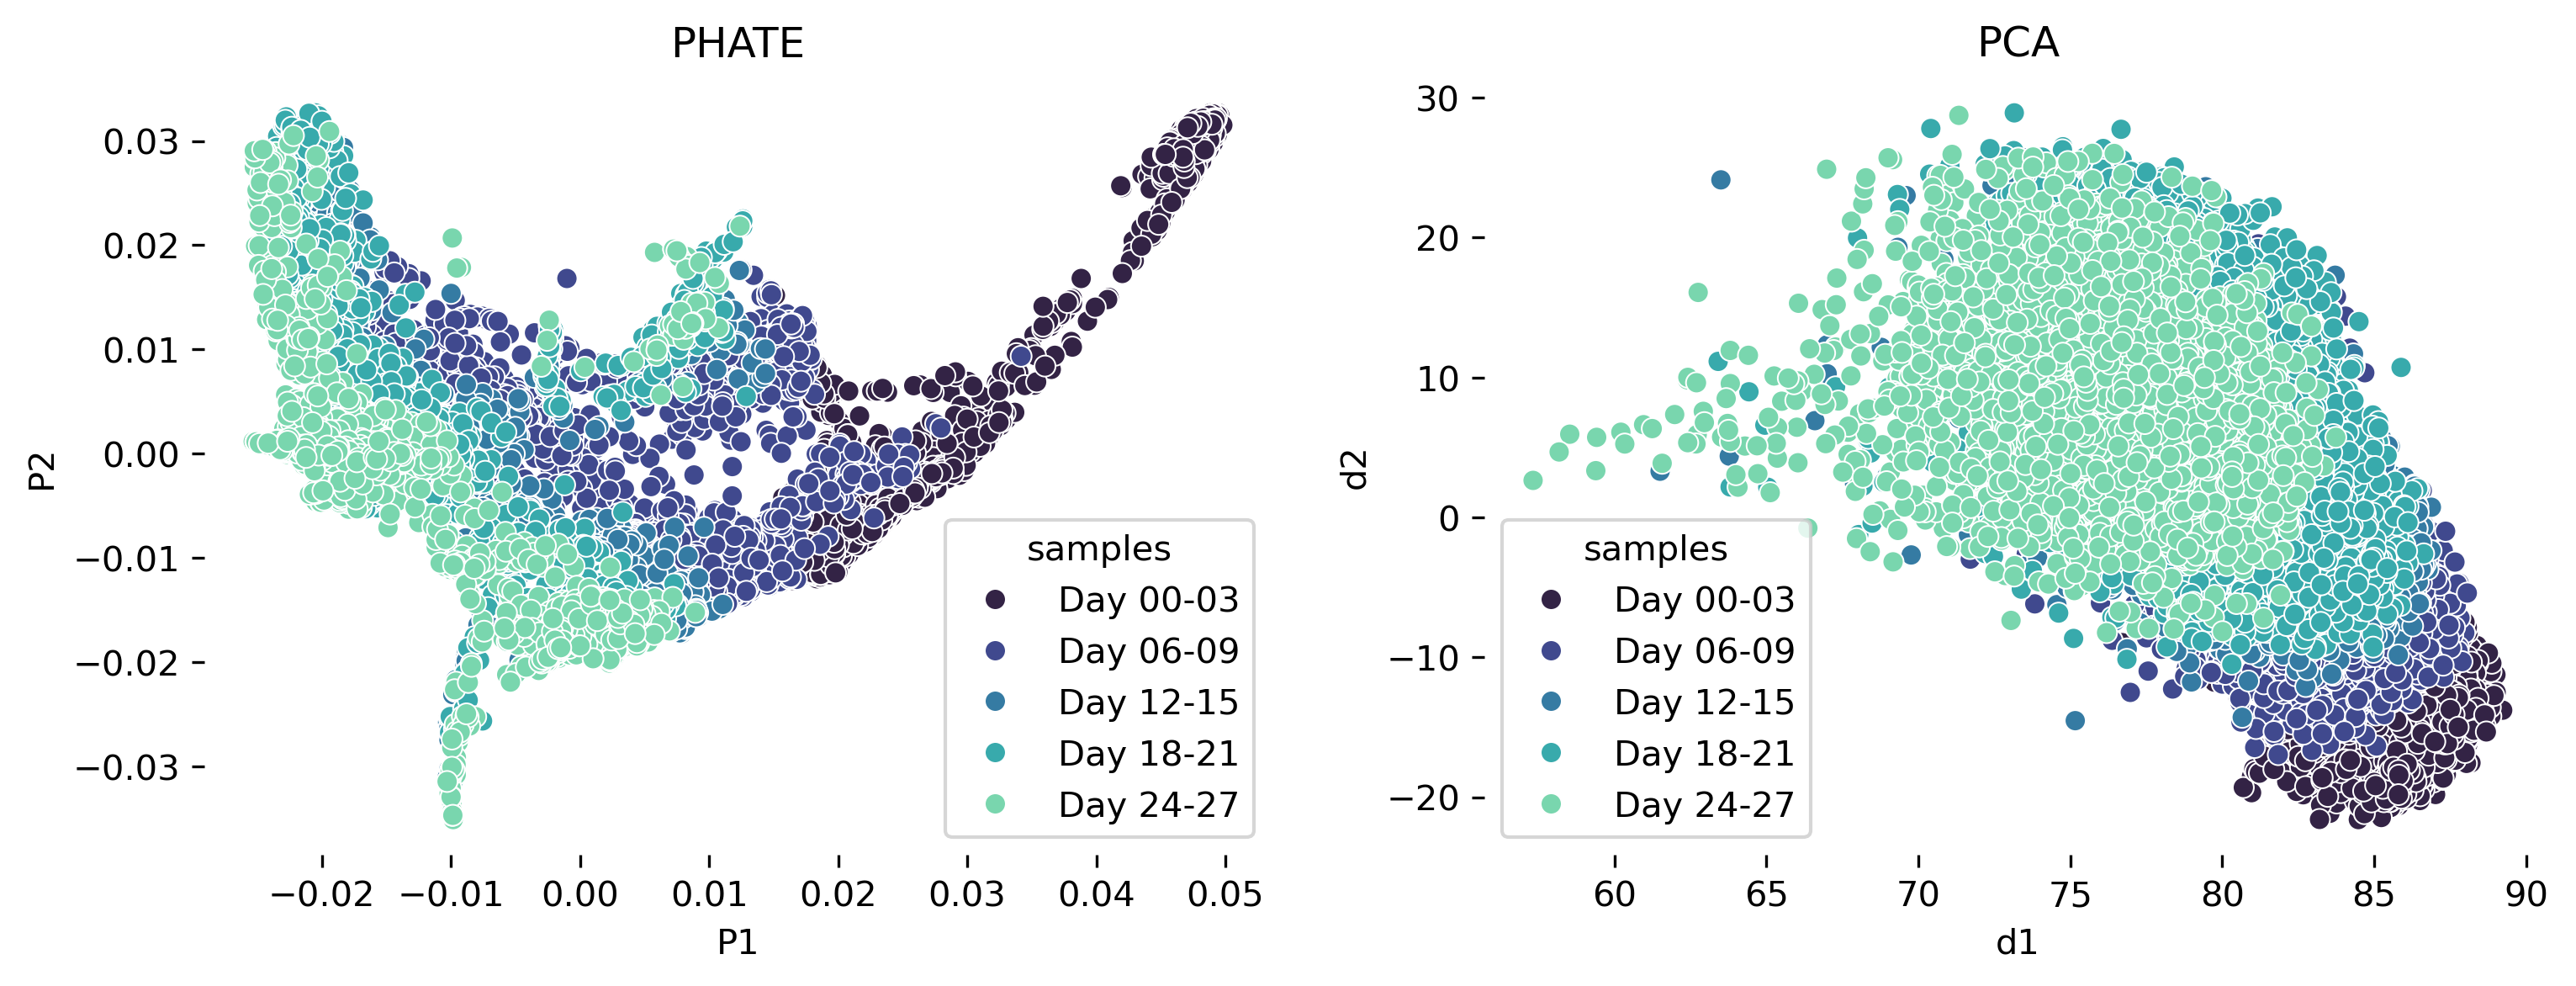

In [50]:
from IPython.display import display, Image

# first phate
display(Image(filename='phate1.png'))

**Original Model Visualizations**

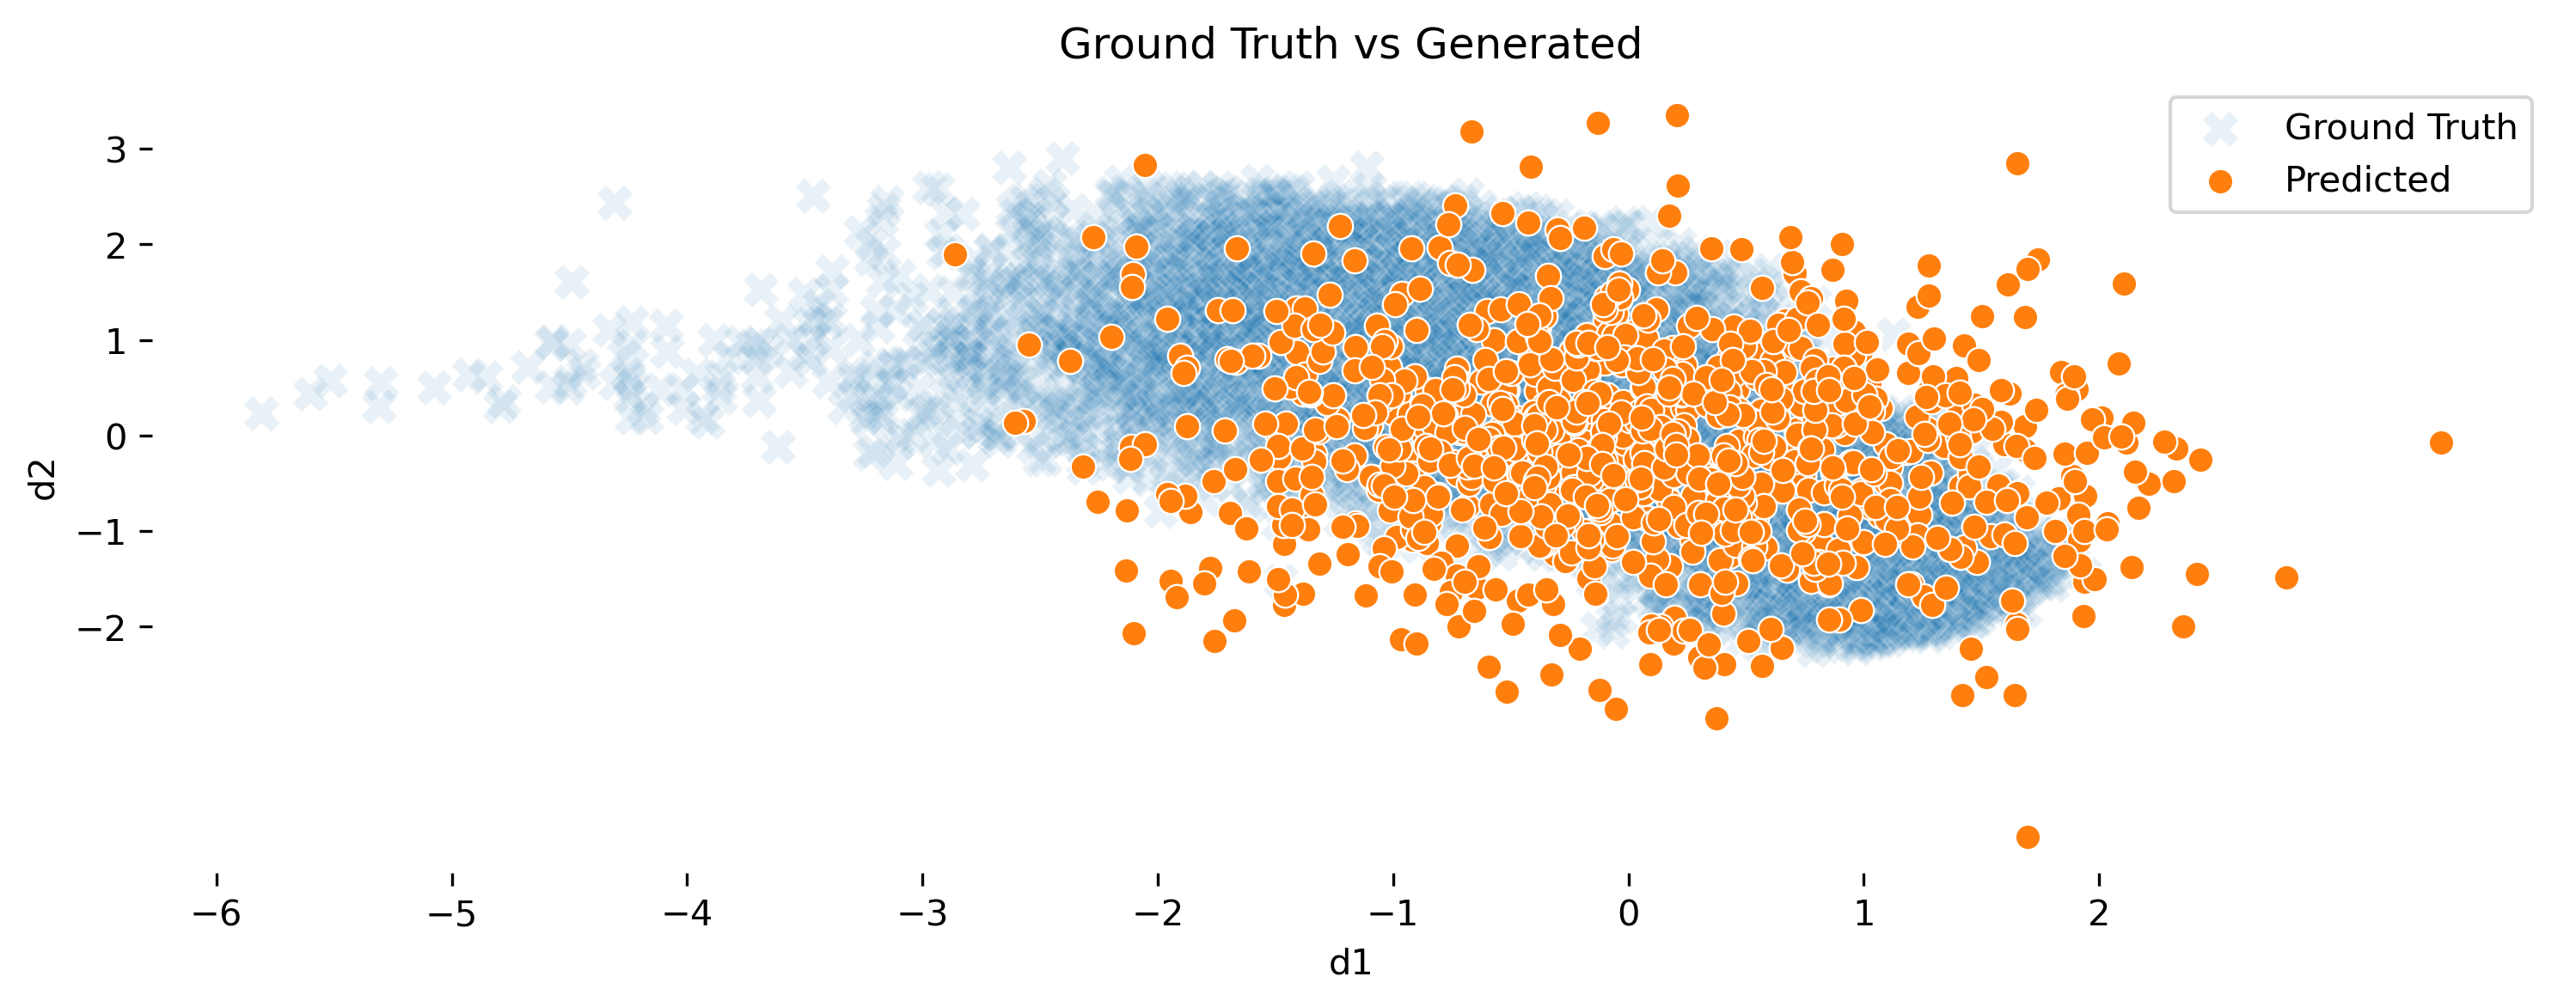

In [51]:
display(Image(filename='original_model_latent.png'))

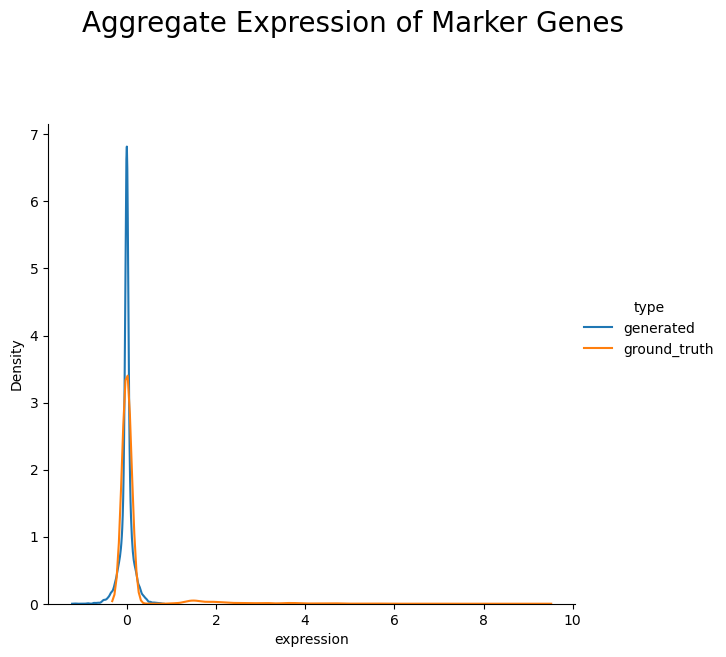

In [52]:
display(Image(filename='agg_express_og.png'))

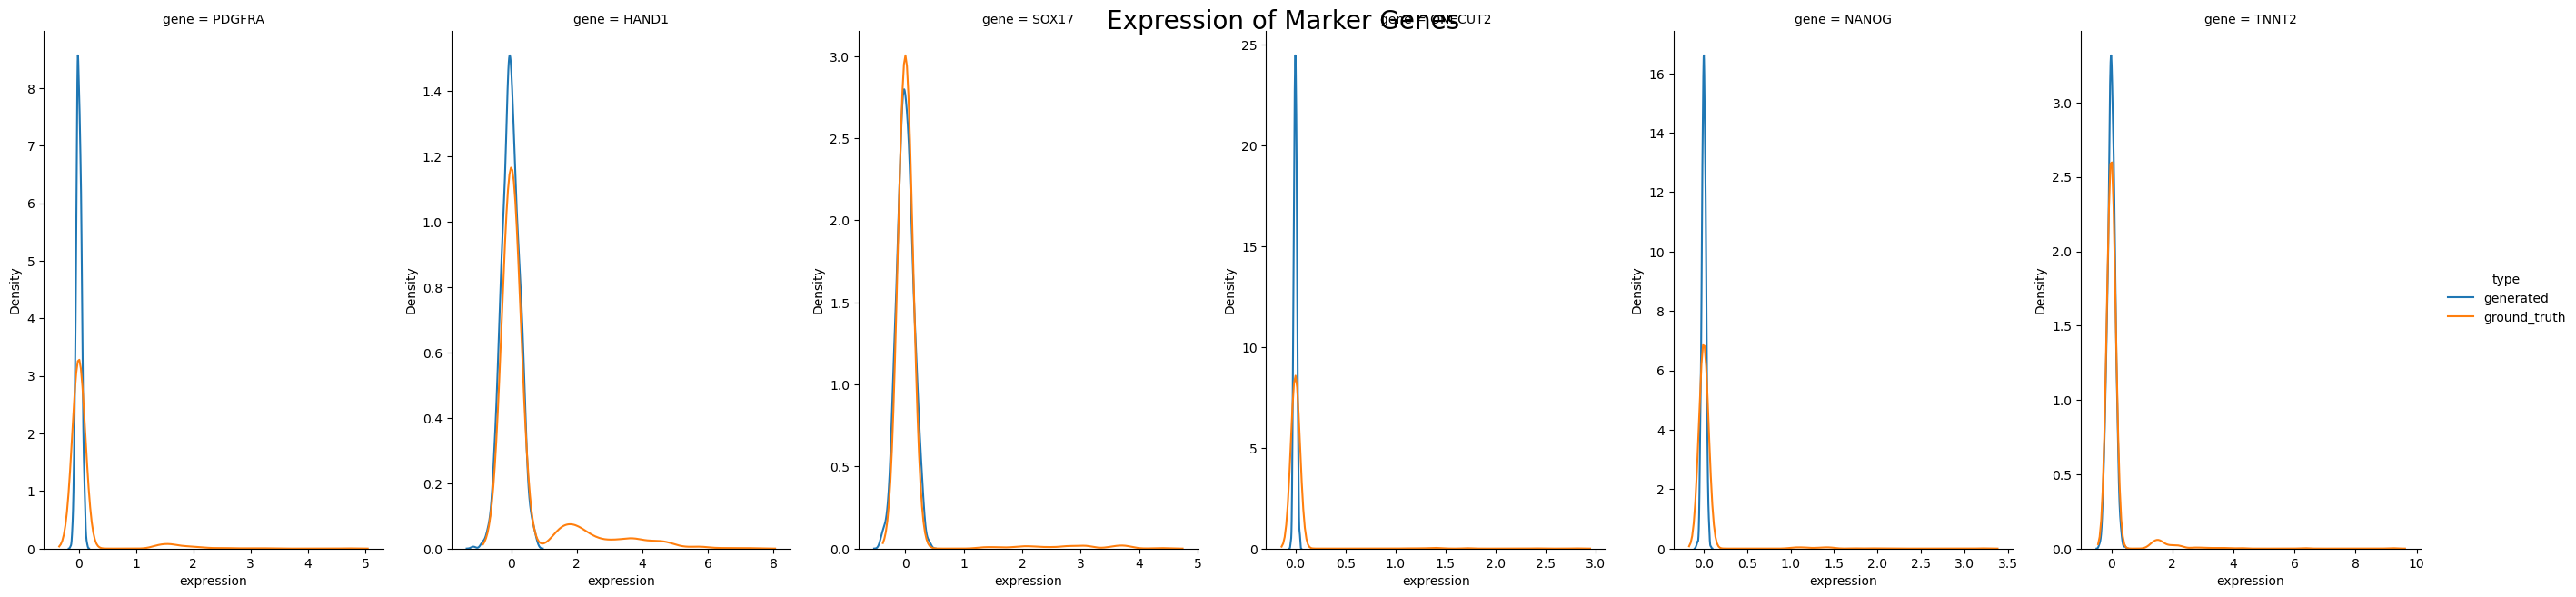

In [53]:
display(Image(filename='gene_exp_og.png'))

**Magnitude Regularized Model Visualizations**

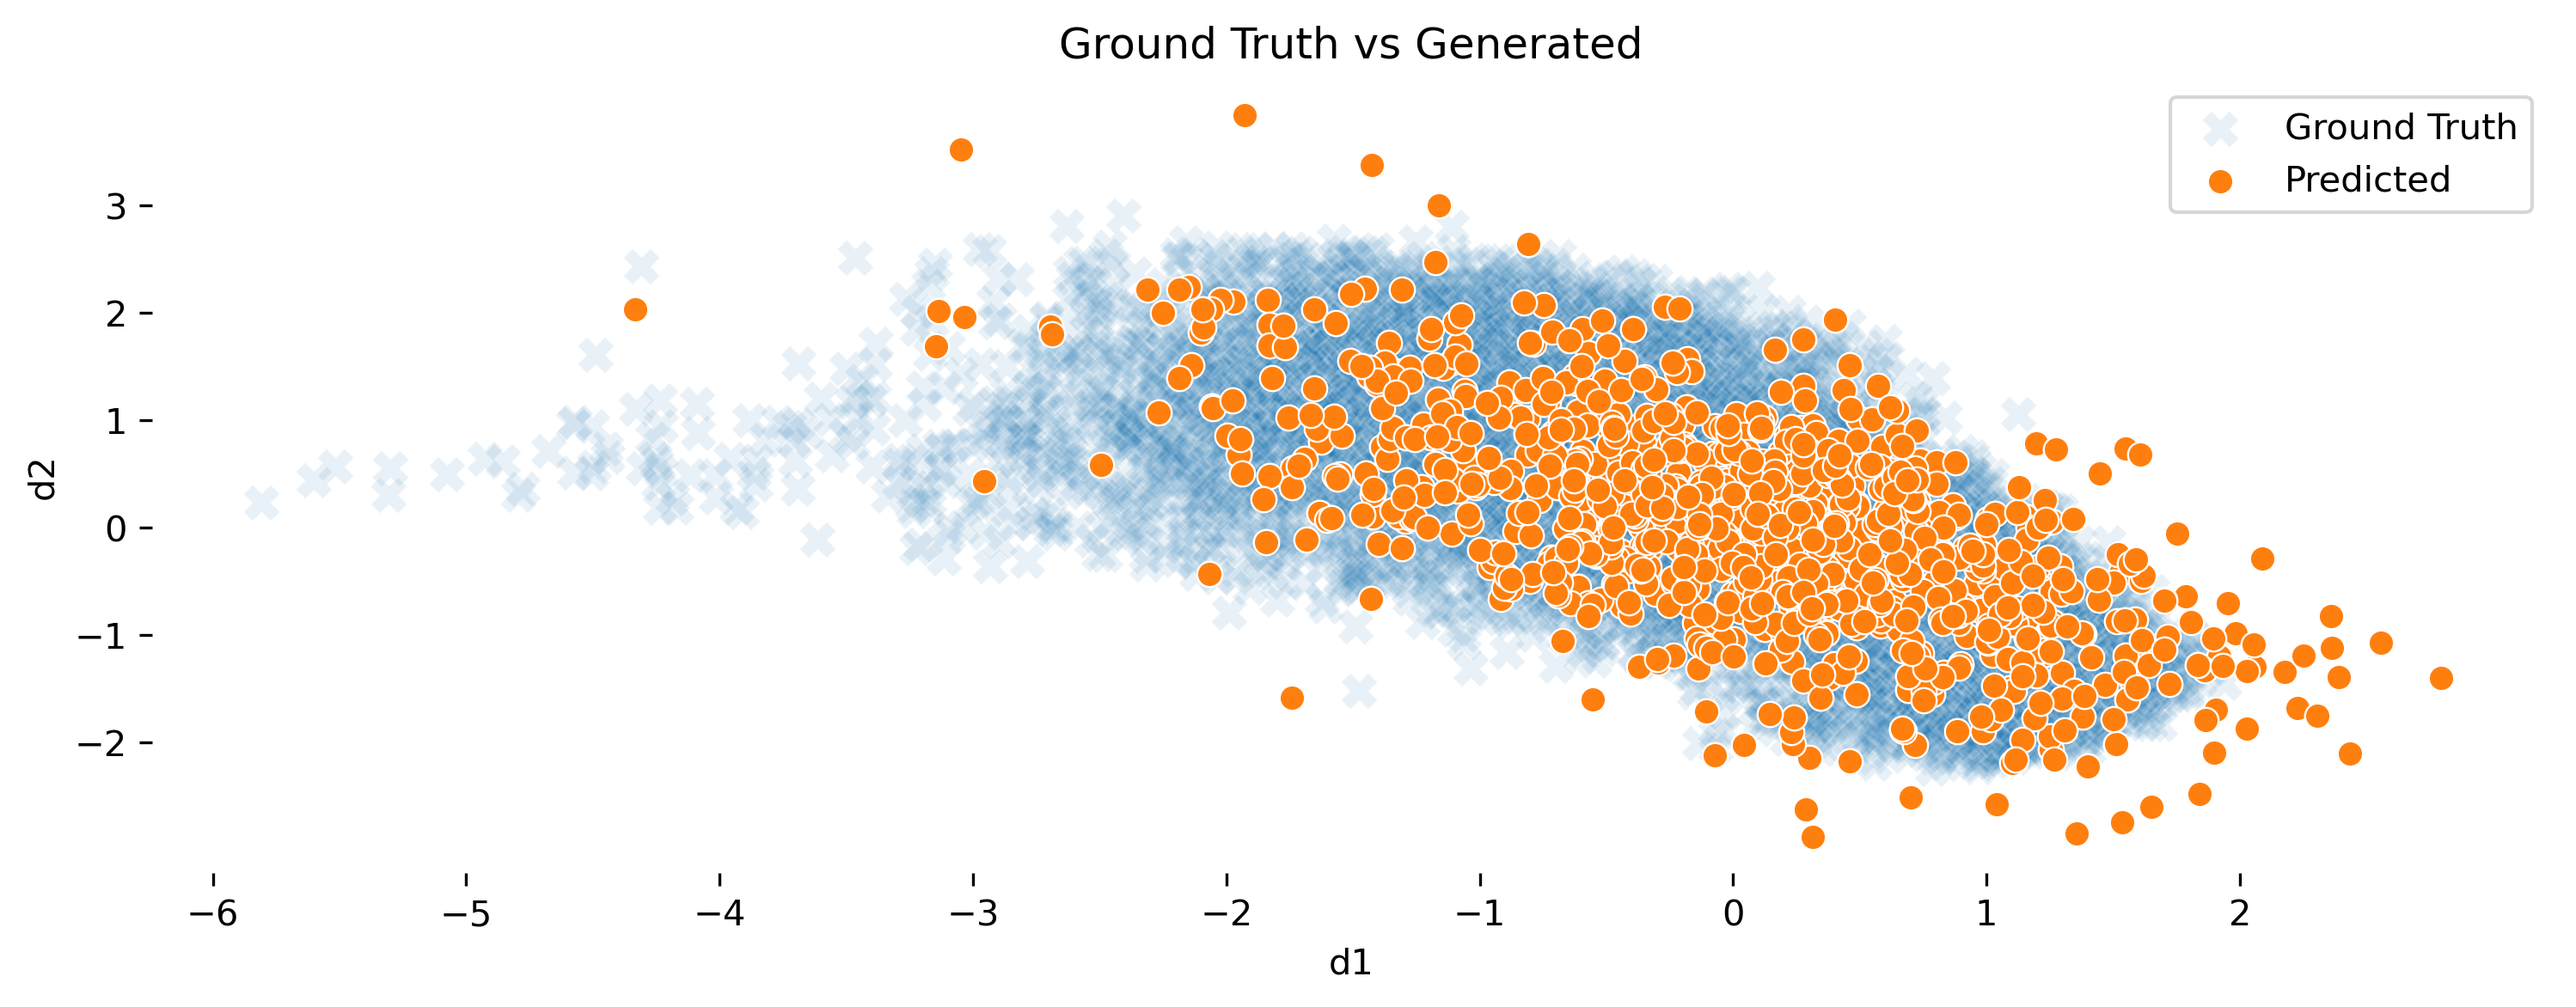

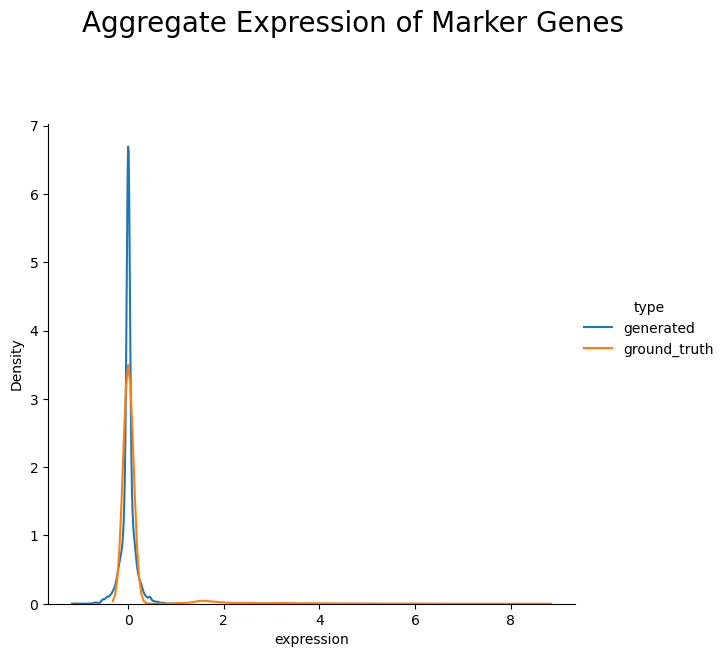

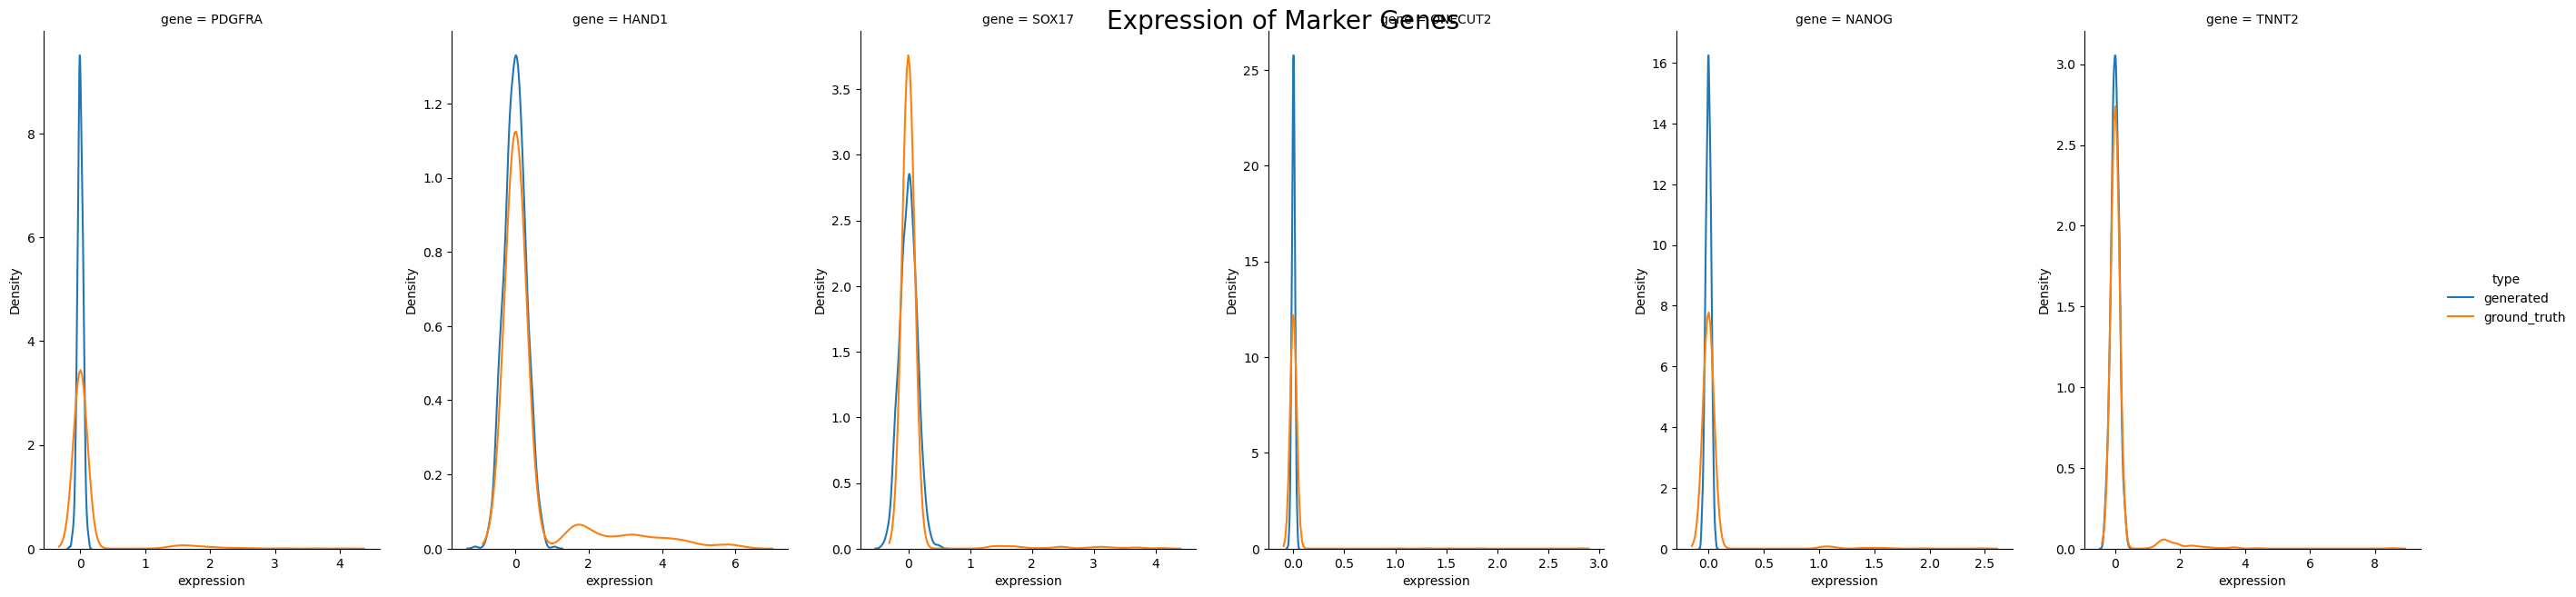

In [92]:
display(Image(filename='improved_model_latent.png'))
display(Image(filename='agg_exp_imp.png'))
display(Image(filename='gene_exp_imp.png'))

# Citations

This problem is inspired by the advances in [Neural ODEs](chen2018node).

[chen2018node]: https://arxiv.org/pdf/1806.07366.pdf
```bibtex
@article{chen2018node
  author    = {Tian Qi Chen and Yulia Rubanova and Jesse Bettencourt and David Duvenaud},
  title     = {Neural Ordinary Differential Equations},
  journal   = {CoRR},
  volume    = {abs/1806.07366},
  year      = {2018},
  url       = {http://arxiv.org/abs/1806.07366},
}
```

The downloading of embryoid data and preprocessing thereof are adapted from the [Embryoid Body for Trajectory Inference](https://github.com/KrishnaswamyLab/TrajectoryNet/blob/master/notebooks/EmbryoidBody_TrajectoryInference.ipynb) notebook as part of the [TrajectoryNet repository](https://github.com/KrishnaswamyLab/TrajectoryNet)


```bibtex
@inproceedings{tong2020trajectorynet,
  title = {TrajectoryNet: A Dynamic Optimal Transport Network for Modeling Cellular Dynamics},
  shorttitle = {TrajectoryNet},
  booktitle = {Proceedings of the 37th International Conference on Machine Learning},
  author = {Tong, Alexander and Huang, Jessie and Wolf, Guy and {van Dijk}, David and Krishnaswamy, Smita},
  year = {2020}
}
```

Further we are grateful to the contributors of [TorchDyn](http://torchdyn.org) which creatly simplifies the implementation of Neural ODEs.

```bibtex
@article{politorchdyn,
  title={TorchDyn: Implicit Models and Neural Numerical Methods in PyTorch},
  author={Poli, Michael and Massaroli, Stefano and Yamashita, Atsushi and Asama, Hajime and Park, Jinkyoo and Ermon, Stefano}
}
```

Additionally we thank [TorchDyn](https://www.pytorchlightning.ai/blog/neural-odes-with-pytorch-lightning-and-torchdyn) and [PyLightning](https://pytorch-lightning.readthedocs.io/en/stable/notebooks/course_UvA-DL/09-normalizing-flows.html) as their tutorials were consulted in the generation of this notebook. In particular special thanks to  [Lilian Weng (@lilianweng)](https://github.com/lilianweng) for her wondeful overview of [Flow Models](https://lilianweng.github.io/posts/2018-10-13-flow-models/), [Michael Poli (@Zymrael)](https://github.com/Zymrael) who produce the [TorchDyn quickstart tutorial](https://github.com/DiffEqML/torchdyn/blob/master/tutorials/00_quickstart.ipynb) [Phillip Lippe (@ohlippe)](https://github.com/phlippe) who authored the [PyLightning normalizing flow tutorial](https://pytorch-lightning.readthedocs.io/en/stable/notebooks/course_UvA-DL/09-normalizing-flows.html).